## TOC:
* [Imports](#import_chapter)
* [Functions](#function_chapter)

## Imports <a class="anchor" id="import_chapter"></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
import keras
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Dataset https://www.kaggle.com/oddrationale/mnist-in-csv

## Functions <a class="anchor" id="function_chapter"></a>

In [2]:
def preprocess_data(csv_data_path):
    
    df = pd.read_csv(csv_data_path)
    y = np.array(df[df.columns[0]].values)
    
    X = []
    df = df.drop(df.columns[0], 1)
    
    for row in df.iloc:
        X.append(row.values.reshape(28, 28))
    
    X = np.array(X)
    
    return X, y
    

## training and testing dataset <a class="anchor" id="datasets"></a>

In [3]:
X_train, y_train = preprocess_data(os.path.join('data', 'mnist', 'mnist_train.csv'))
X_test, y_test = preprocess_data(os.path.join('data', 'mnist', 'mnist_test.csv'))

C:\Users\HUBERT~1\AppData\Local\Temp/ipykernel_16868/2312660549.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(df.columns[0], 1)


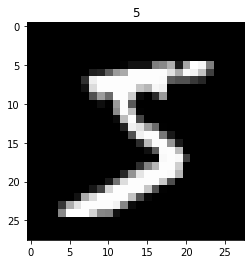

In [4]:
plt.imshow(X_train[0], cmap='gray')
plt.title(str(y_train[0]))
plt.show()

In [5]:
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

In [6]:
X_train = X_train / 255.
X_test = X_test / 255.

In [7]:
img_shape = (28, 28, 1)
batch_size = 32
latent_dim = 2

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = keras.backend.random_normal(shape=(keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + keras.backend.exp(z_log_var) * epsilon

In [3]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = keras.backend.flatten(x)
        z_decoded = keras.backend.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * keras.backend.mean(1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var), axis=-1)
        loss = keras.backend.mean(xent_loss + kl_loss)
        return loss
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [14]:
input_img = keras.Input(img_shape)

x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = keras.backend.int_shape(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)

z_mean = keras.layers.Dense(latent_dim)(x)
z_log_var = keras.layers.Dense(latent_dim)(x)

z = keras.layers.Lambda(sampling)([z_mean, z_log_var])

decoder_input = keras.layers.Input(keras.backend.int_shape(z)[1:])

x = keras.layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

x = keras.layers.Reshape(shape_before_flattening[1:])(x)
x = keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = keras.layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = keras.models.Model(decoder_input, x)

z_decoded = decoder(z)

y = CustomVariationalLayer()([input_img, z_decoded])




In [15]:
vae = keras.models.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 28, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_5[0][0]']               
                                                                                            

In [16]:
vae.fit(x=X_train, y=None,
       shuffle=True,
       epochs=20,
       batch_size=batch_size,
       validation_data=(X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - ETA: 0s - loss: 466.9631

c:\users\hubertmazur\desktop\fs-di_strony_internetowe\venv\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 116s 2ms/sample - loss: 466.9631 - val_loss: 0.2004
Epoch 2/20
60000/60000 [==============================] - 118s 2ms/sample - loss: 0.1962 - val_loss: 0.1926
Epoch 3/20
60000/60000 [==============================] - 117s 2ms/sample - loss: 0.1904 - val_loss: 0.1876
Epoch 4/20
60000/60000 [==============================] - 117s 2ms/sample - loss: 0.1875 - val_loss: 0.1881
Epoch 5/20
60000/60000 [==============================] - 114s 2ms/sample - loss: 0.1856 - val_loss: 0.1851
Epoch 6/20
60000/60000 [==============================] - 113s 2ms/sample - loss: 0.1842 - val_loss: 0.1828
Epoch 7/20
60000/60000 [==============================] - 115s 2ms/sample - loss: 0.1831 - val_loss: 0.1826
Epoch 8/20
60000/60000 [==============================] - 114s 2ms/sample - loss: 0.1822 - val_loss: 0.1823
Epoch 9/20
60000/60000 [==============================] - 115s 2ms/sample - loss: 0.1814 - val_loss: 0.1830
Epoch 10/20
60000/60000 [============

In [17]:
decoder.save('decoder.h5')
vae.save('vae.h5')

In [18]:
encoder = keras.models.Model(input_img, z_mean)
encoder.save('encoder.h5')

In [19]:
colors = ['#DFFF00', '#FFBF00', '#FF7F50', '#DE3163',
          '#9FE2BF', '#40E0D0', '#6495ED', '#CCCCFF',
          '#FF00FF', '#008080']
labels = range(0, 11)

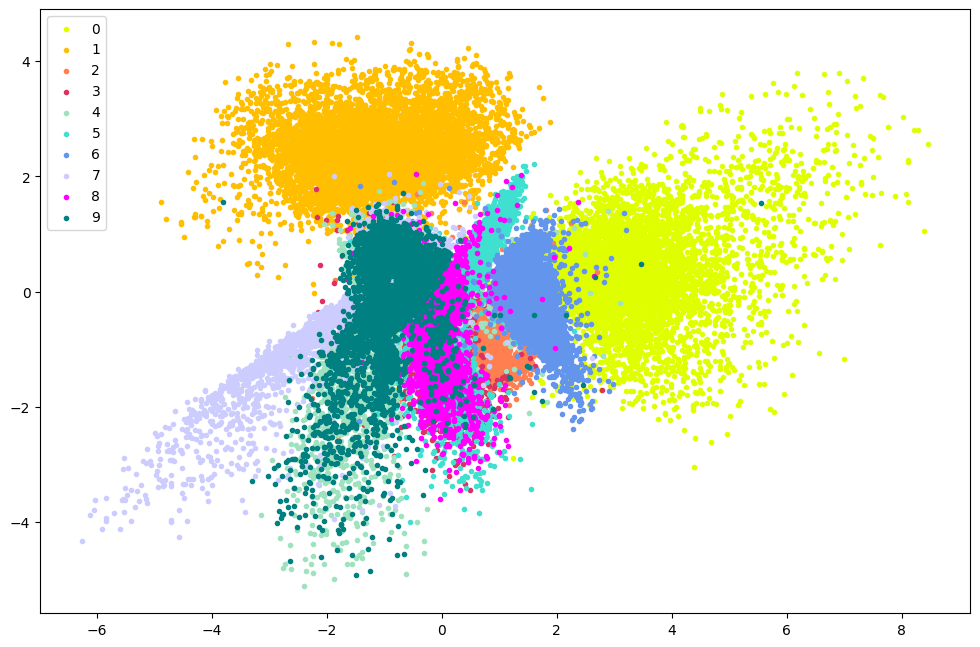

In [22]:
for color, label in zip(colors, labels):
    sub_dataset = X_train[y_train == label]
    points = encoder.predict(sub_dataset)
    plt.scatter(points[:, 0], points[:, 1], c=color, label=label, marker='.')
plt.legend(loc='best')
plt.show()
    

In [5]:
model = tf.keras.models.load_model('decoder.h5', custom_objects={'CustomVariationalLayer': CustomVariationalLayer})

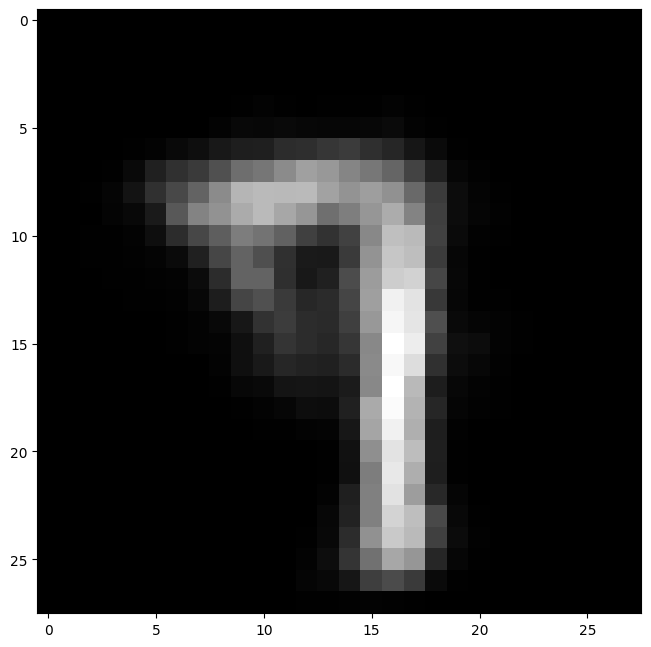

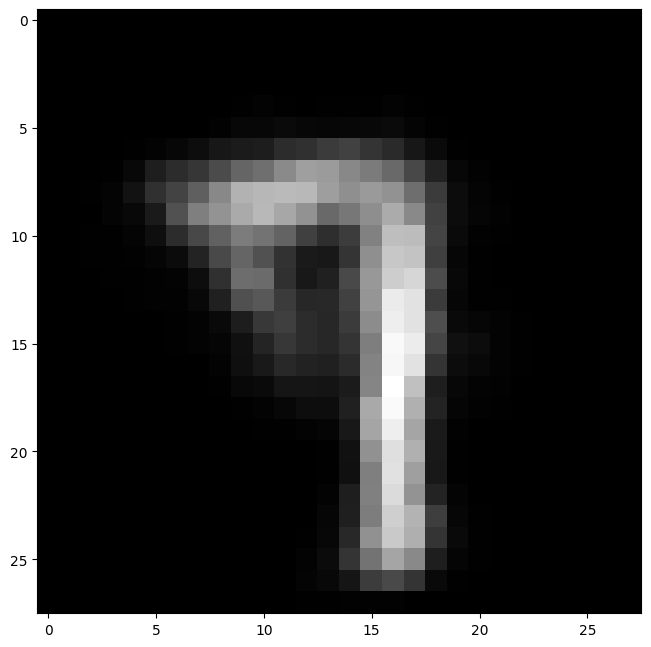

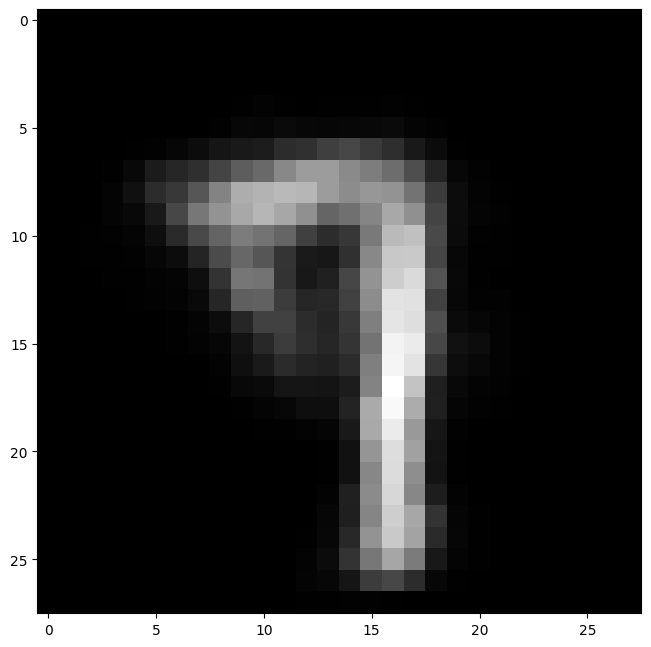

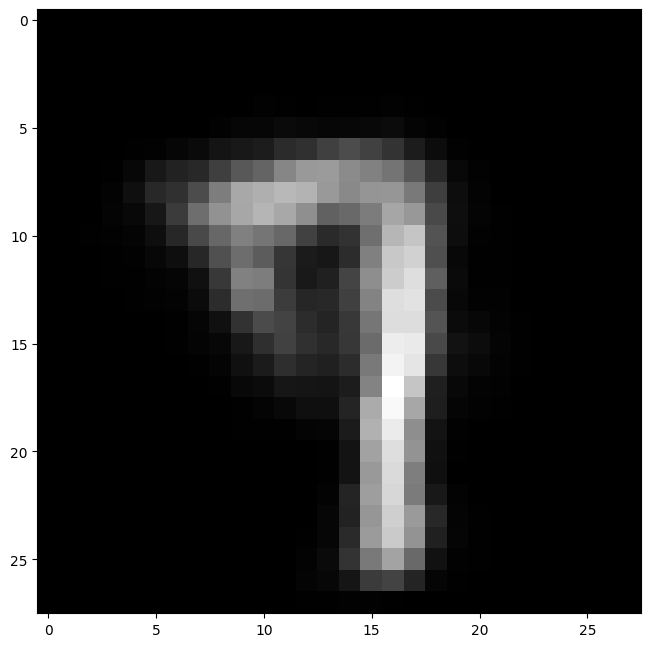

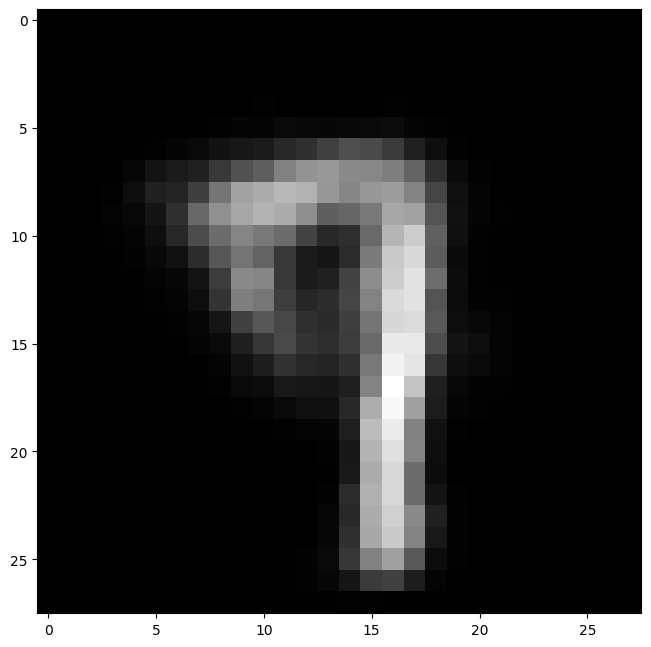

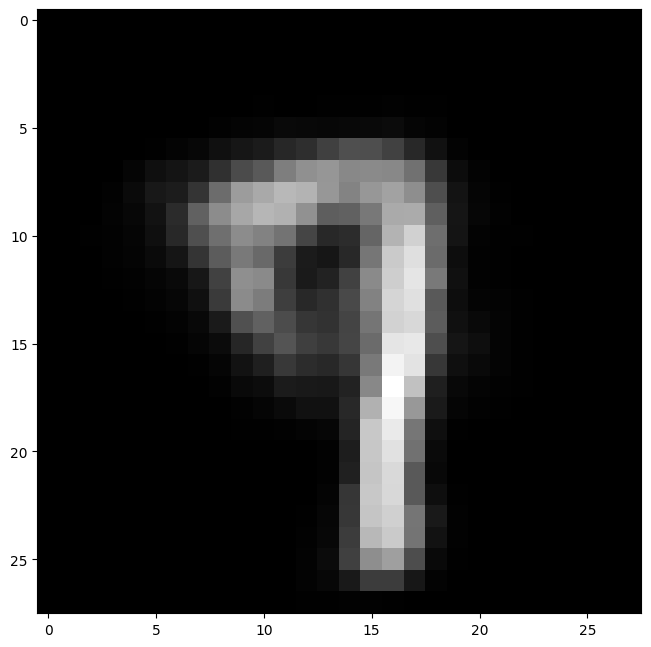

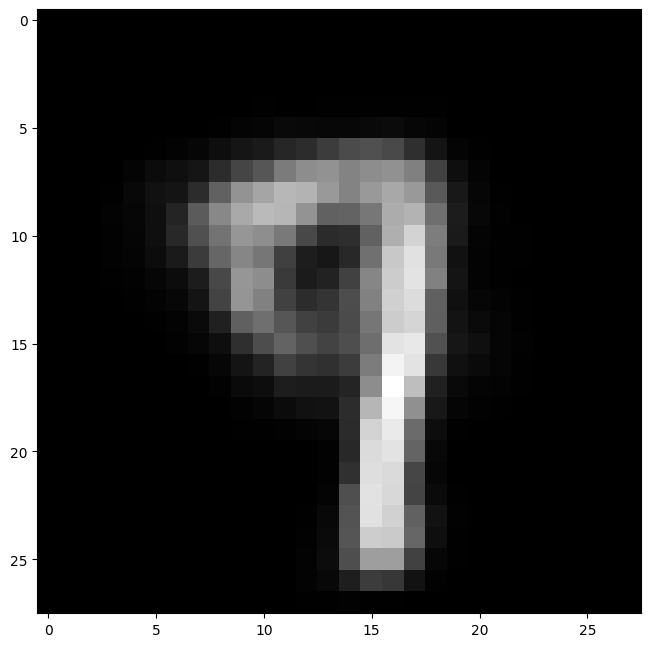

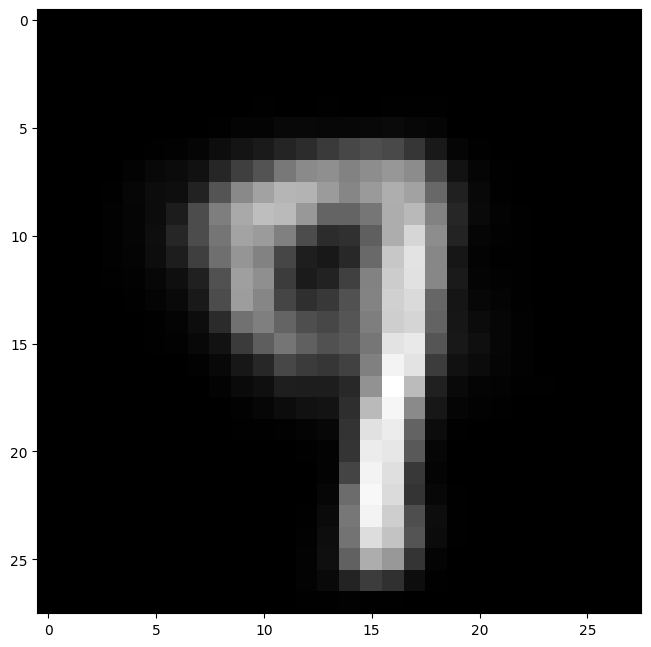

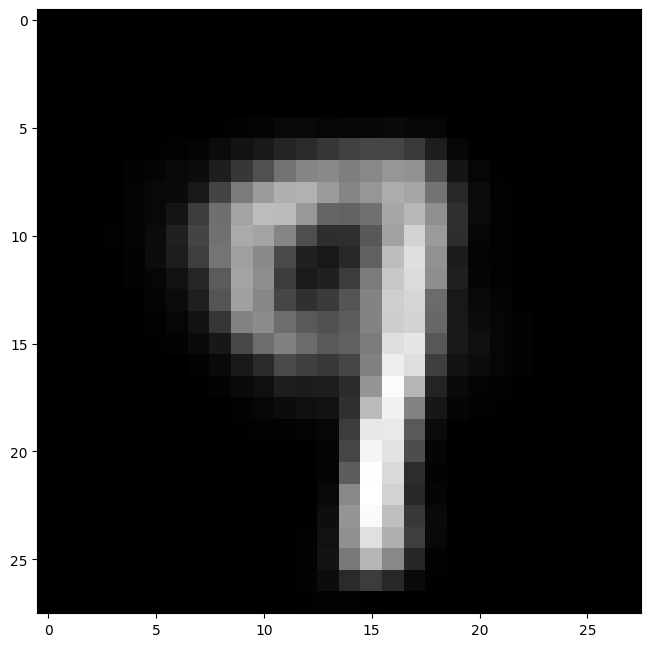

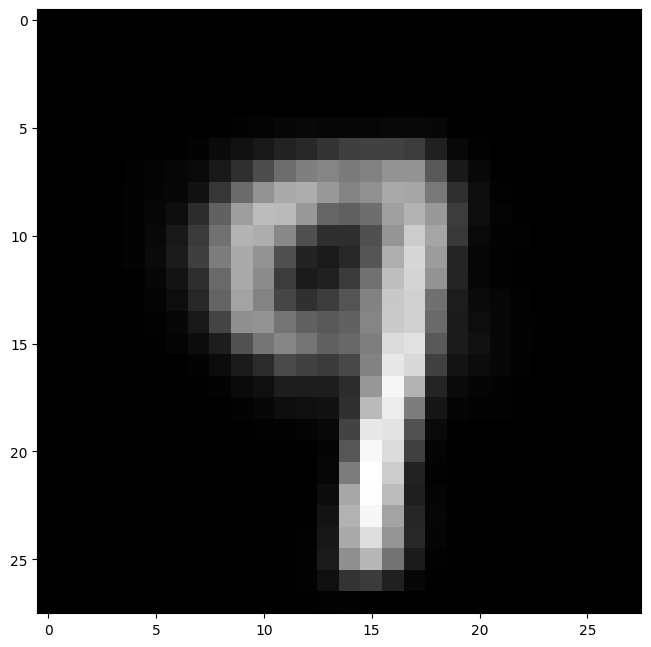

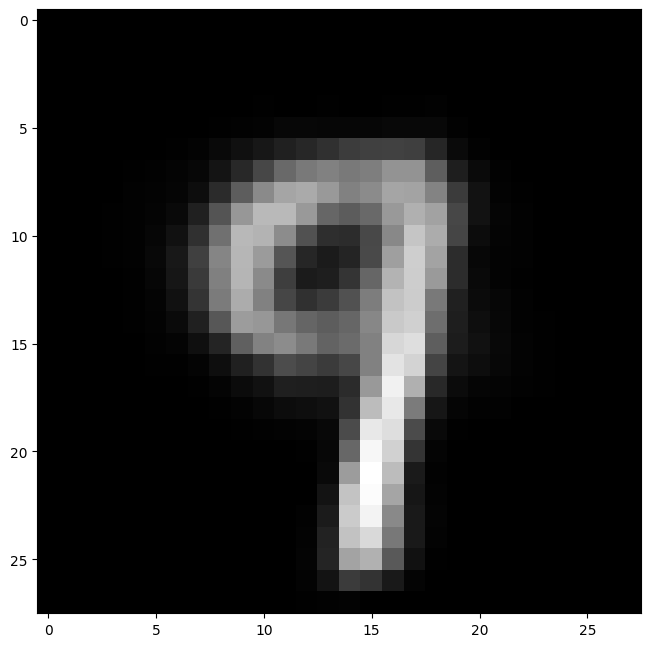

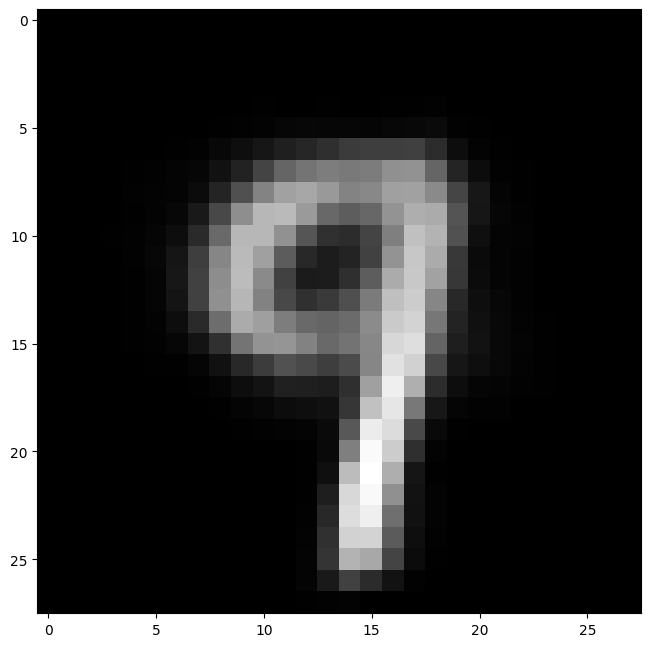

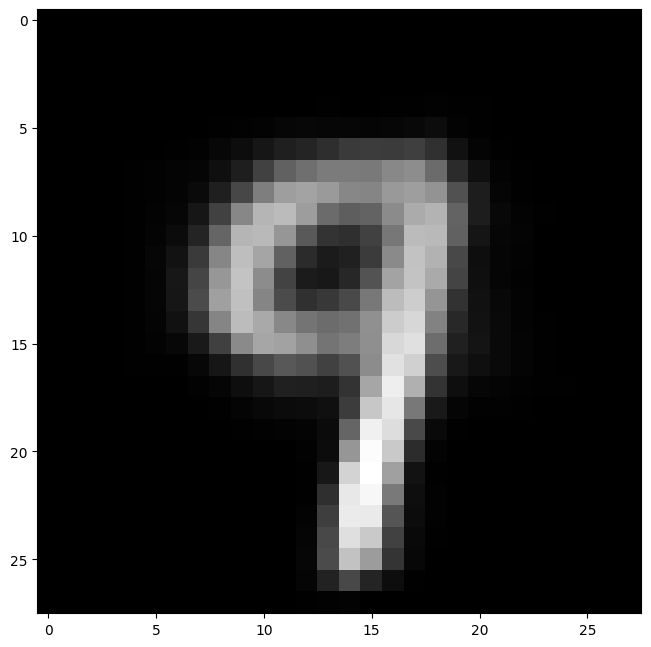

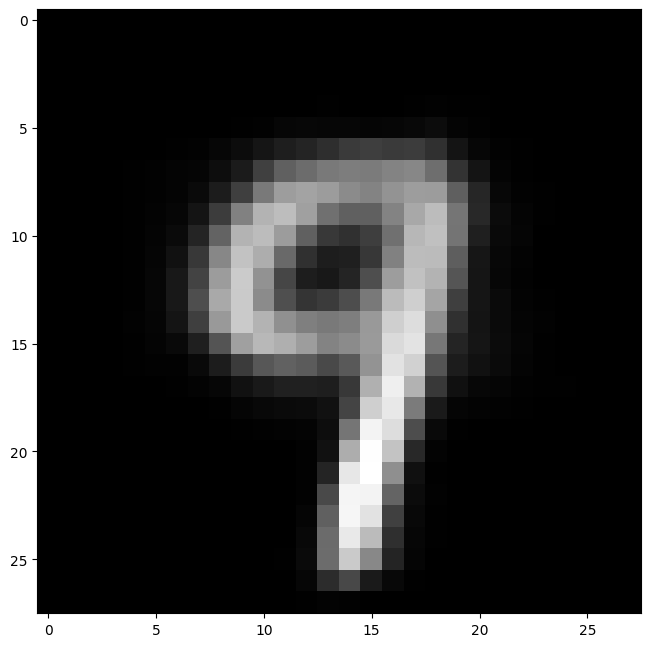

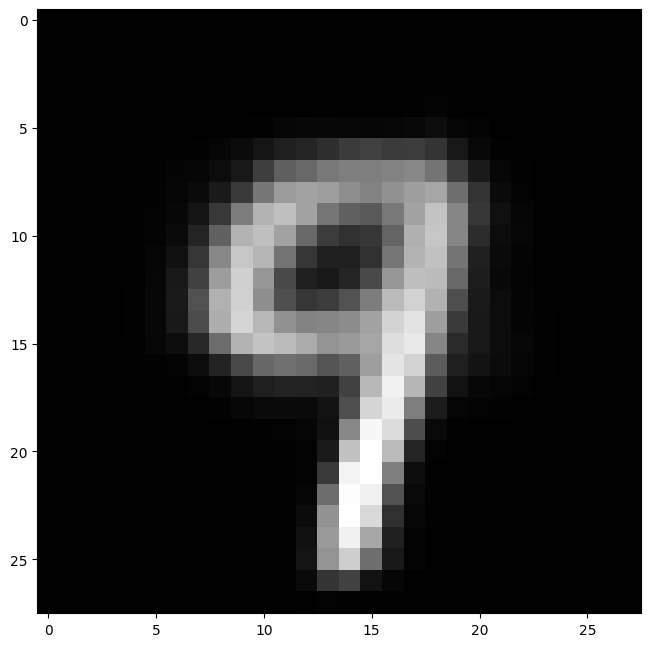

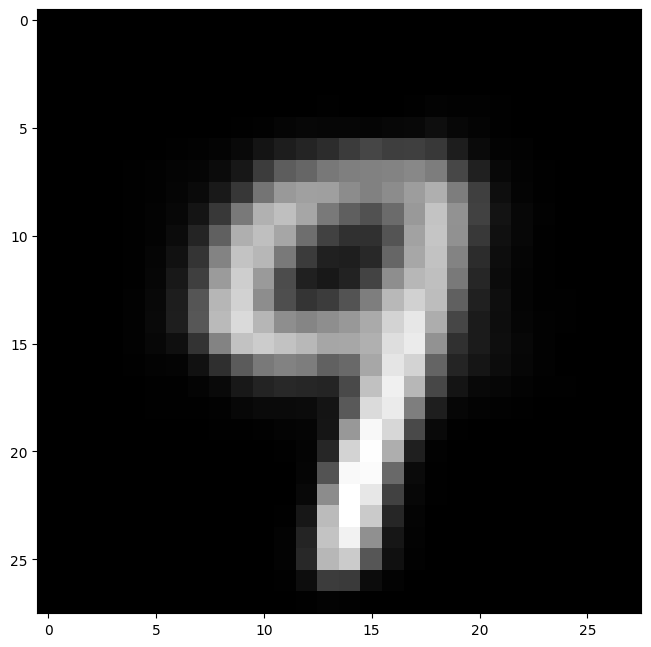

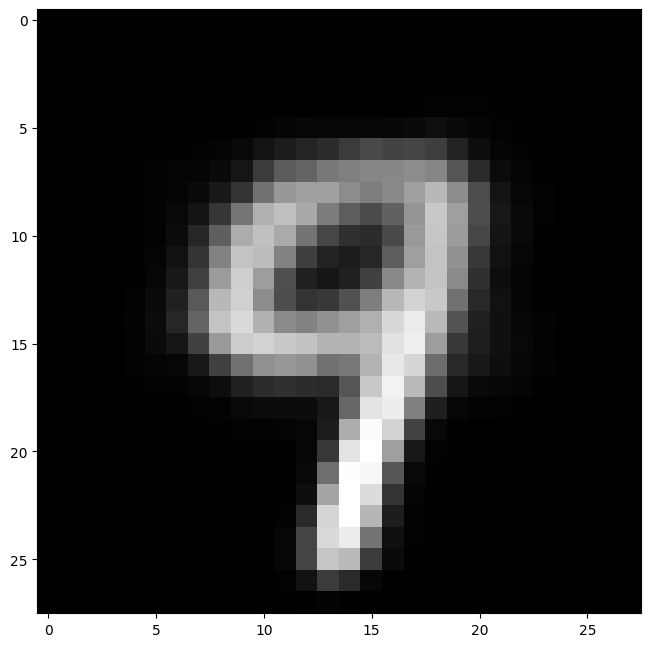

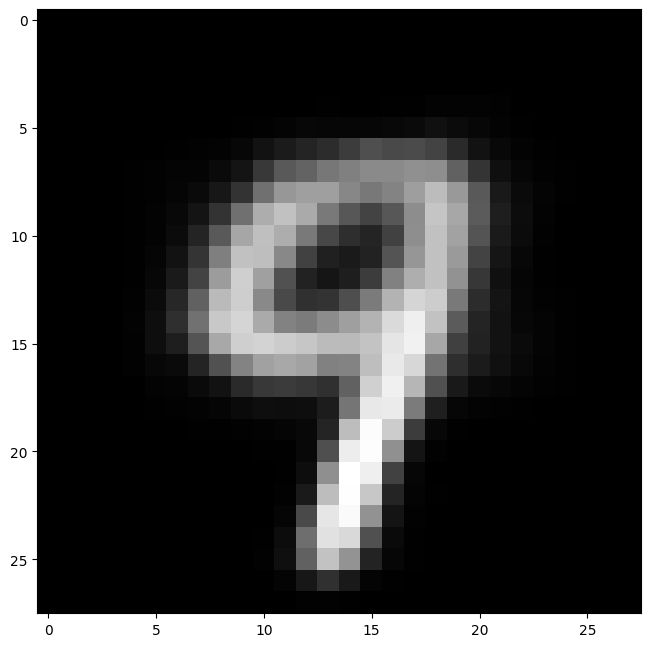

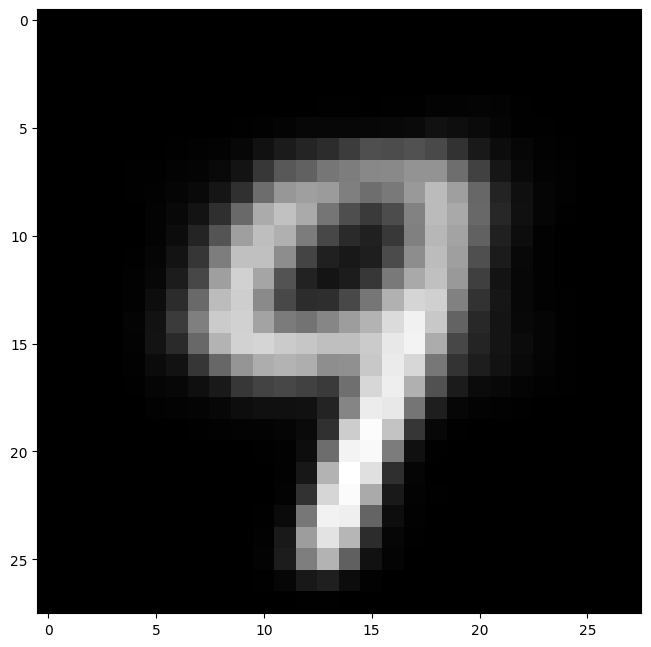

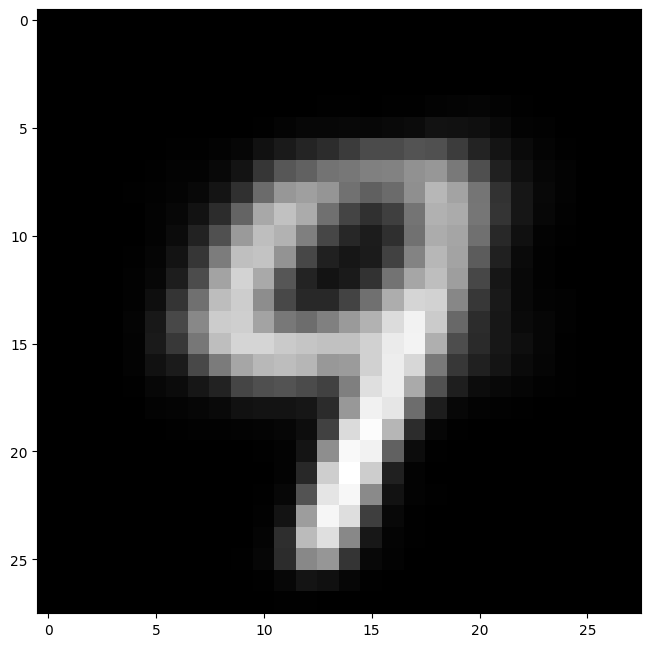

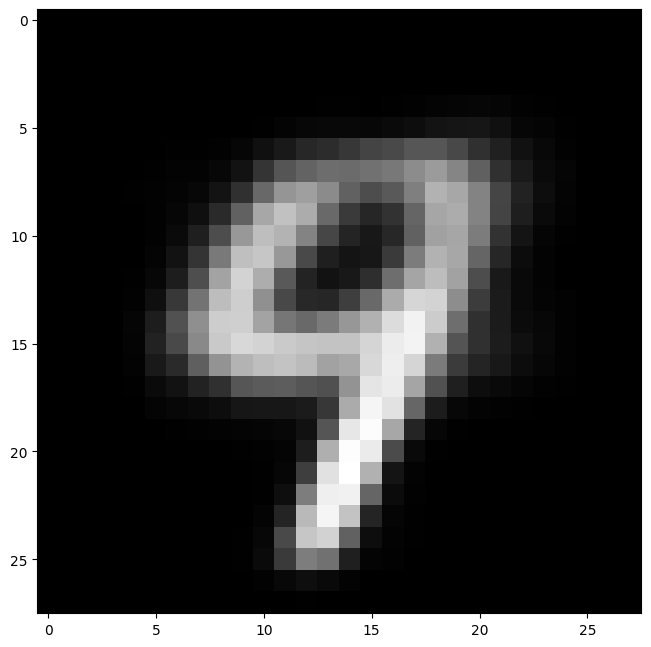

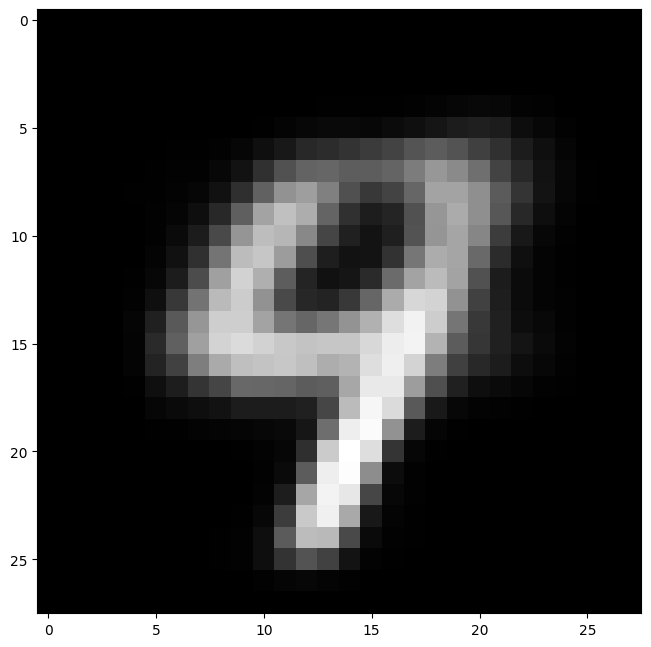

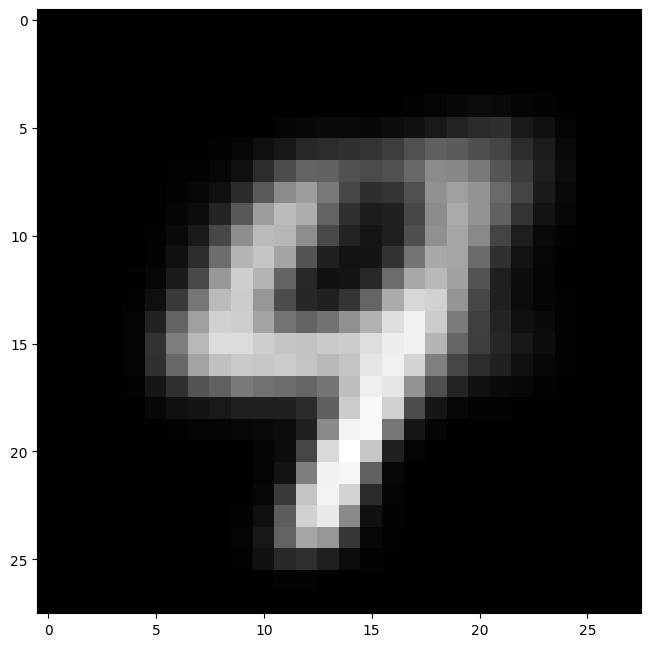

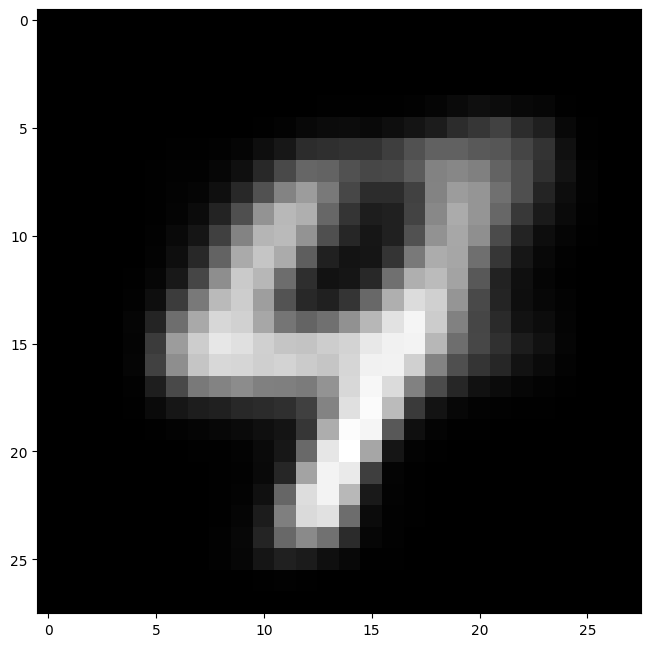

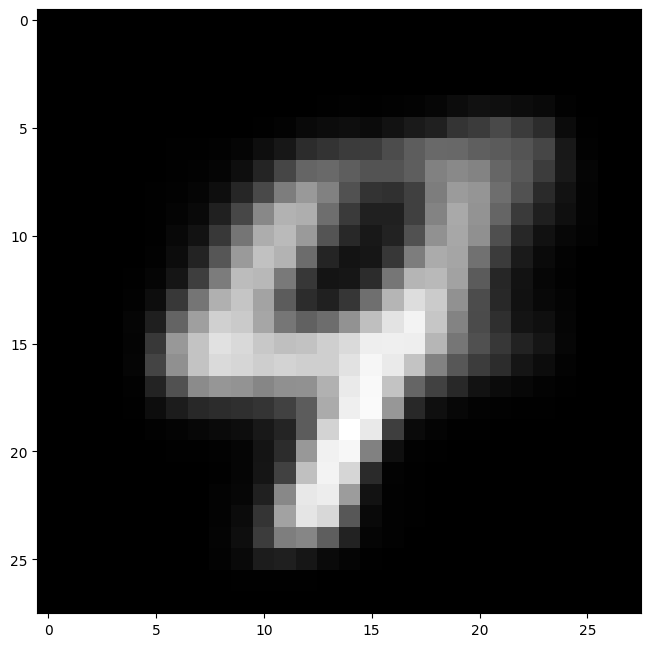

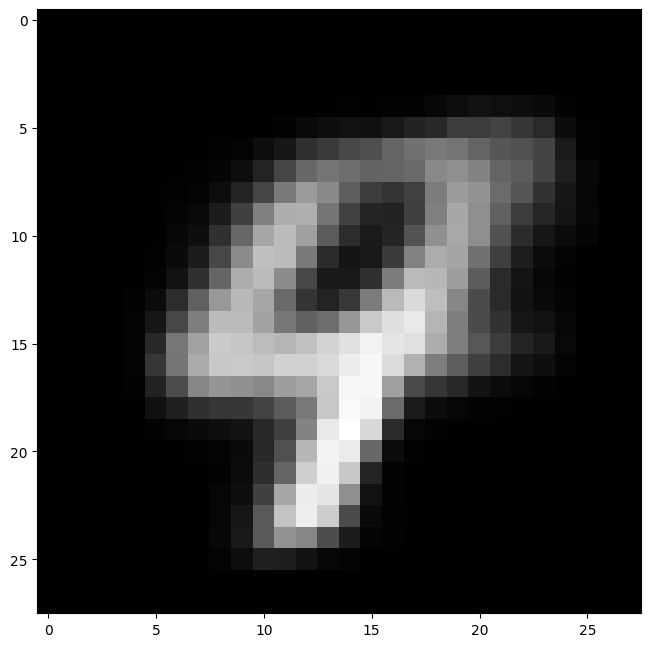

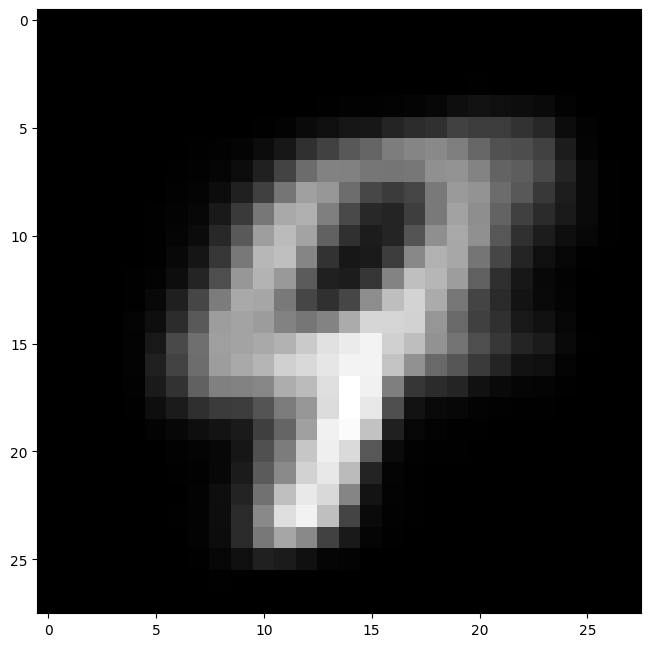

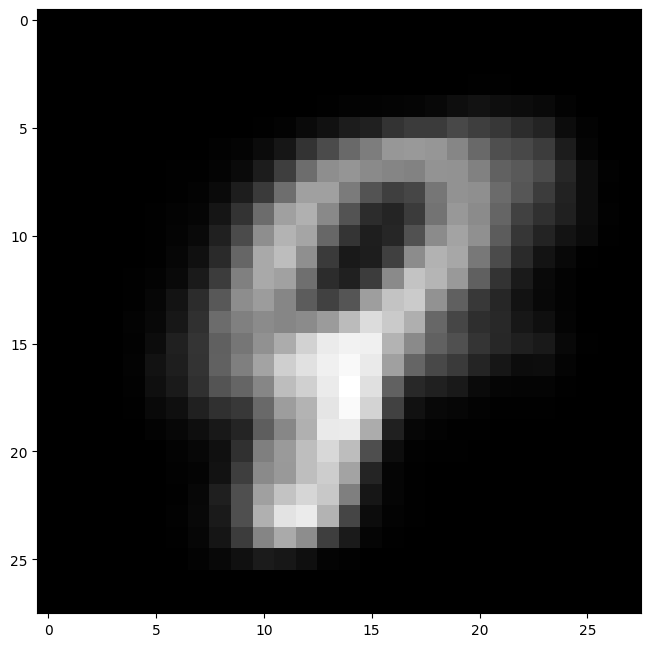

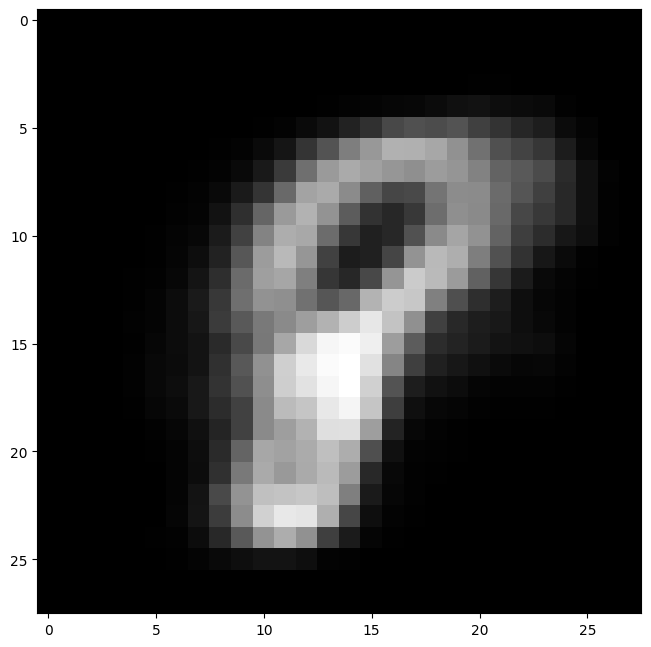

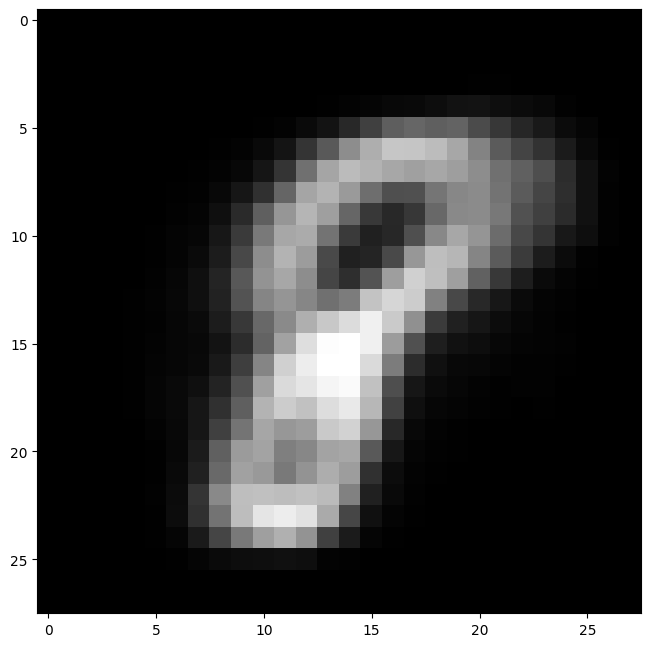

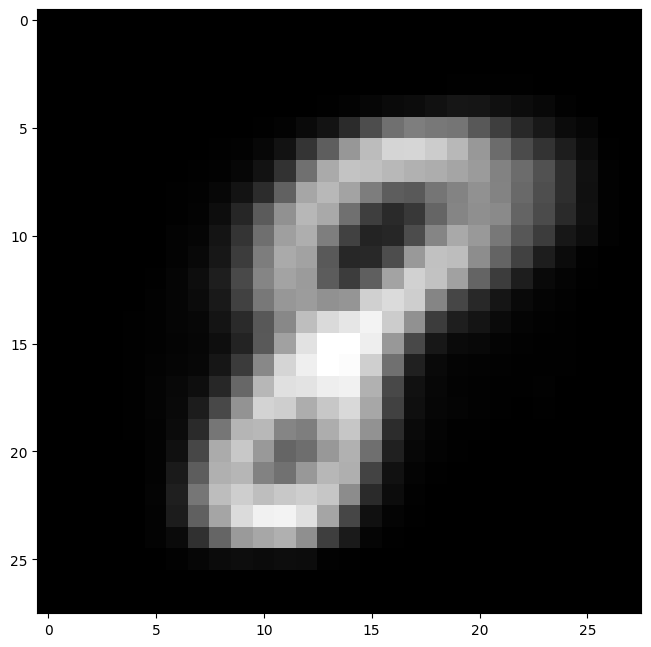

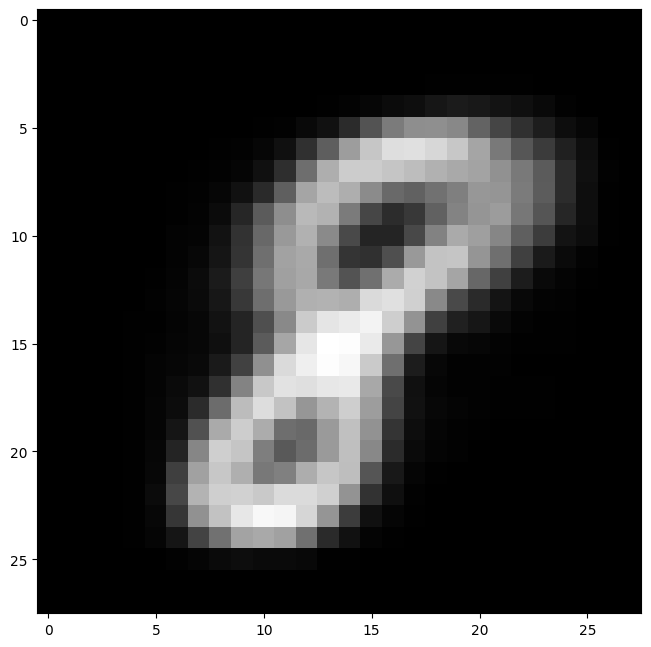

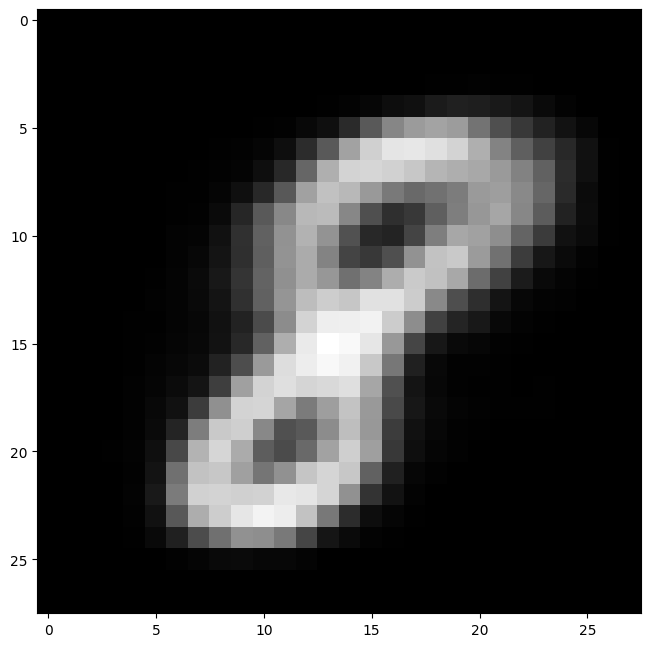

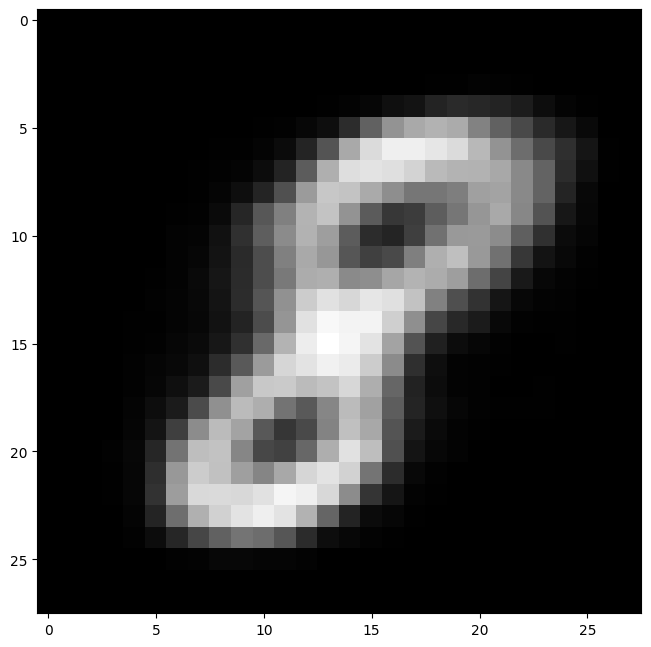

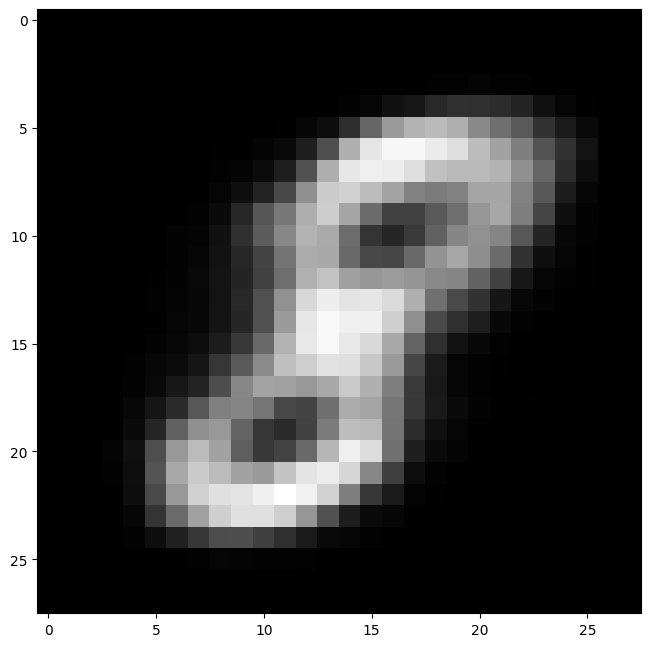

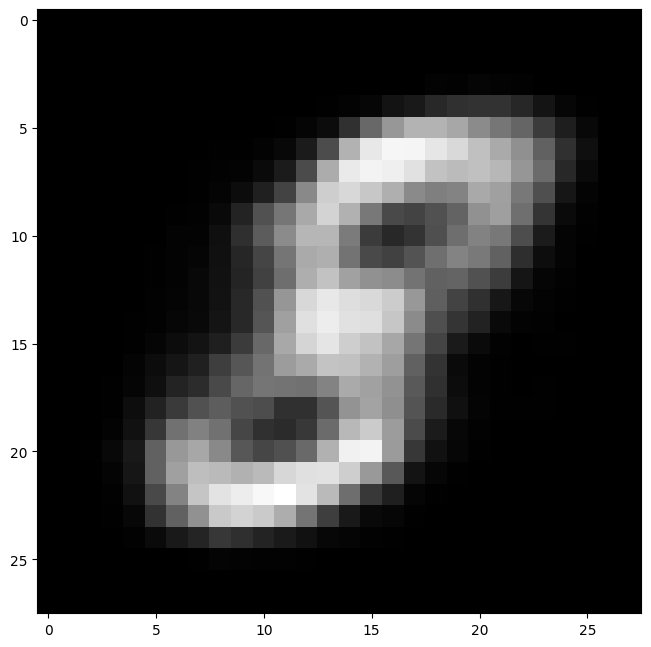

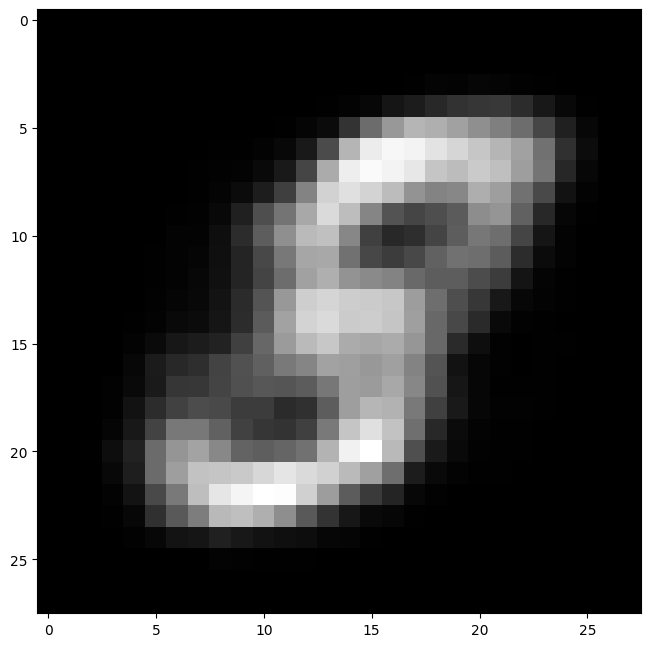

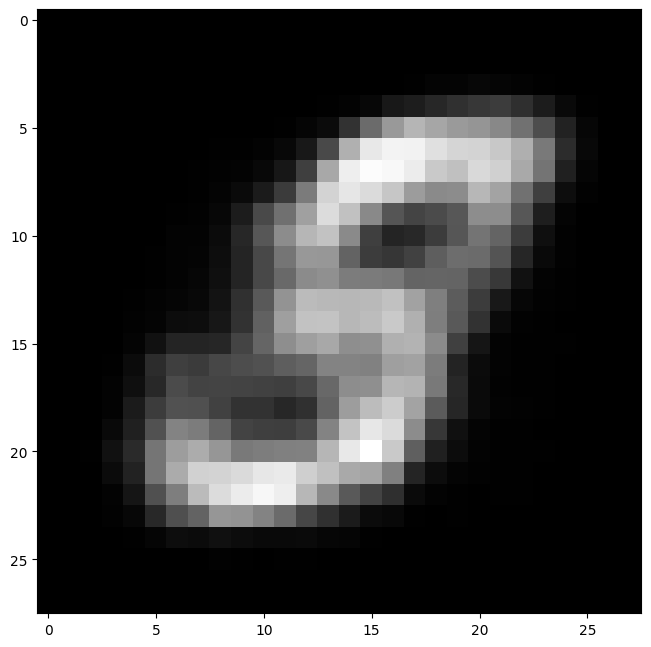

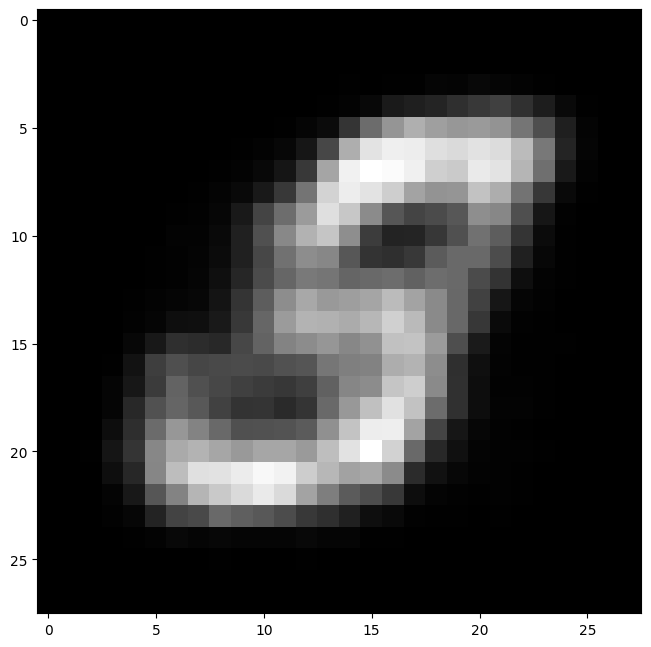

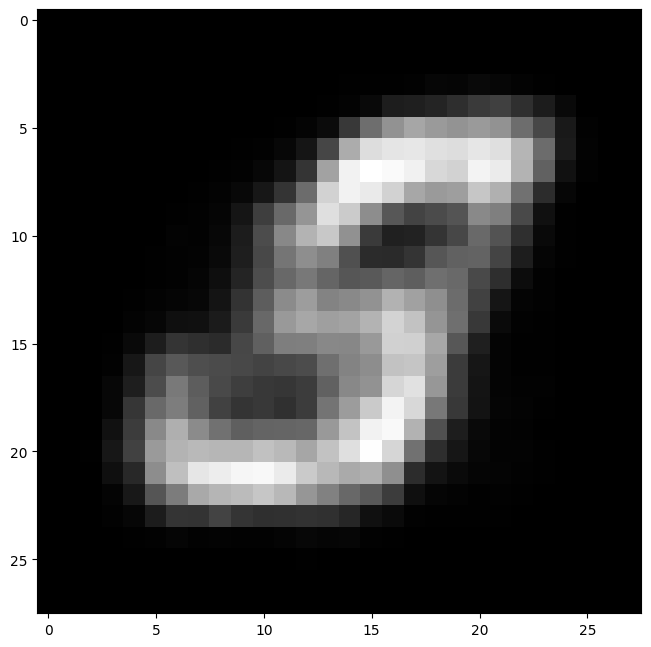

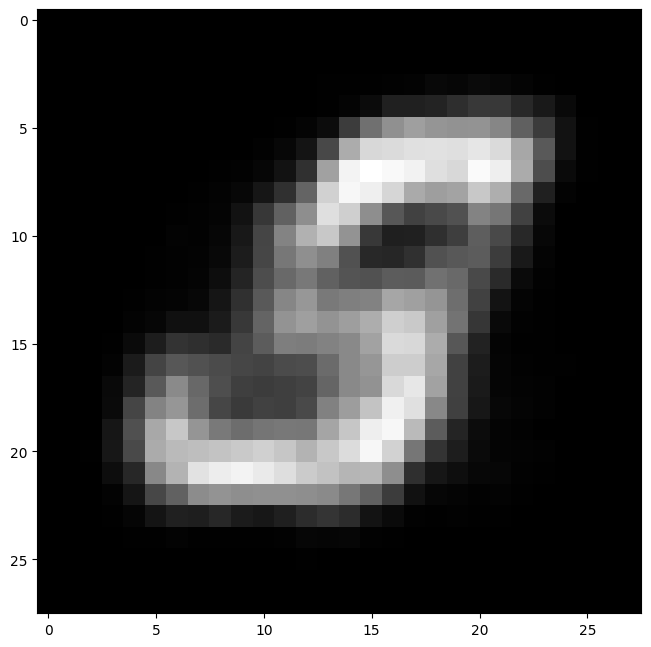

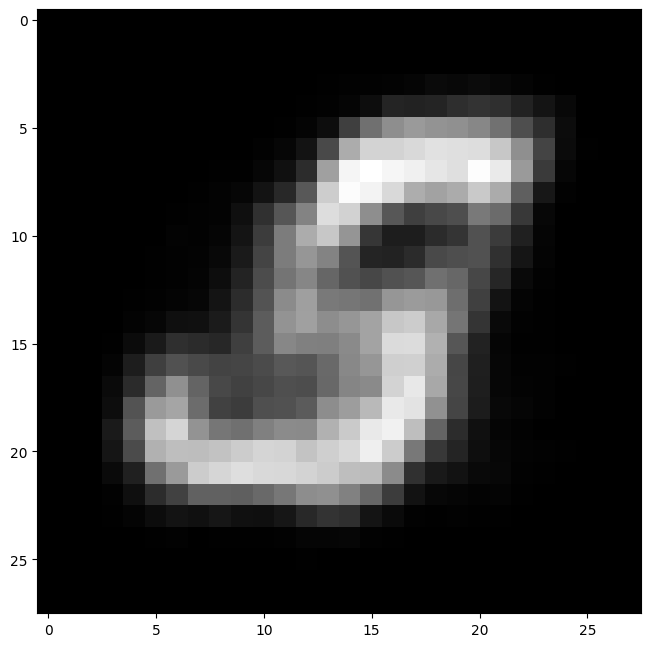

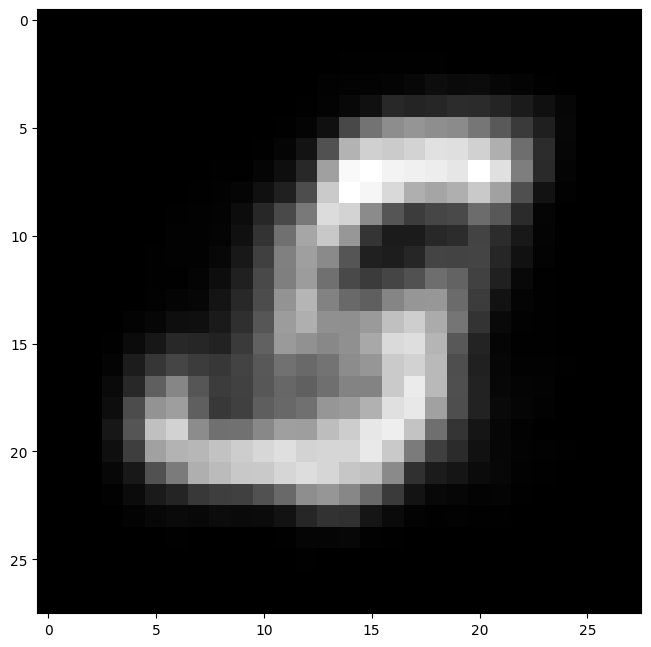

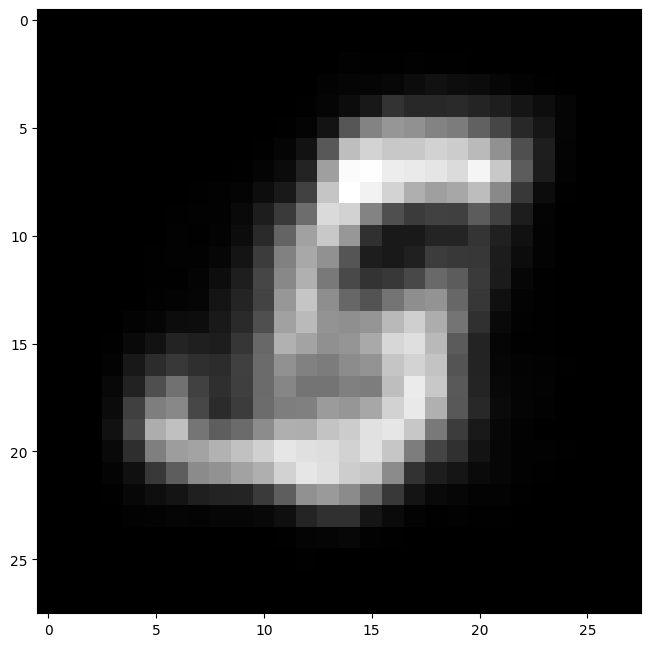

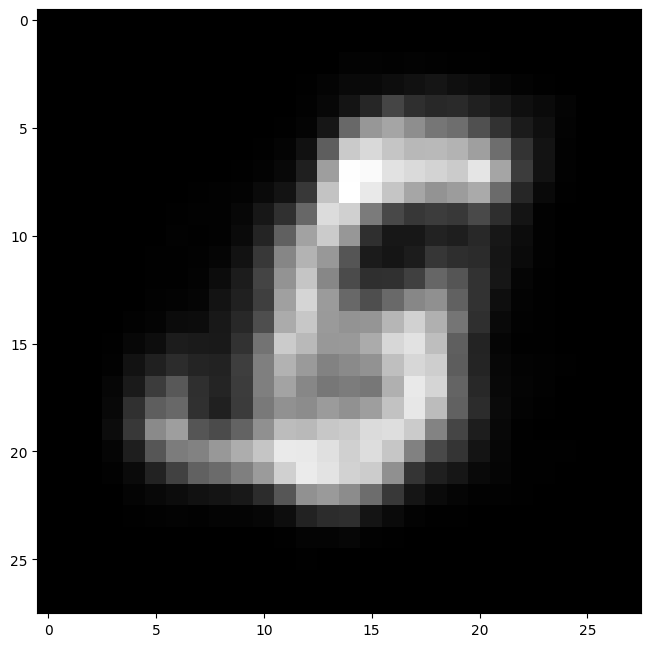

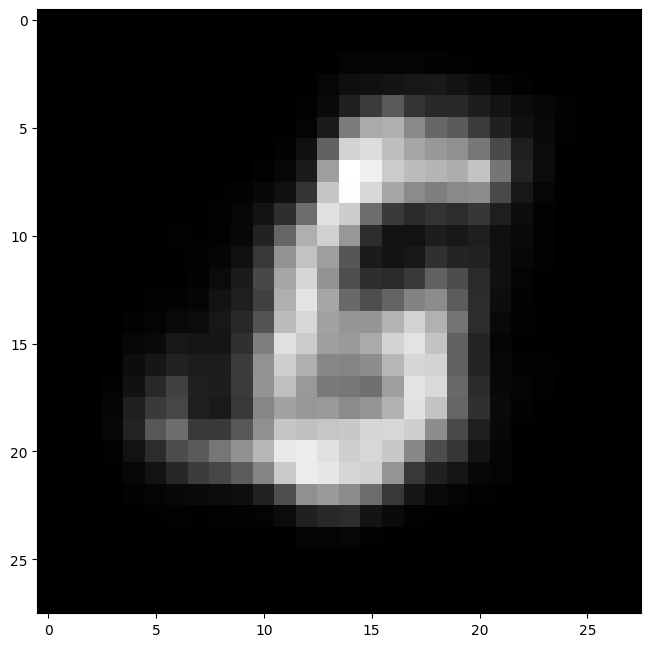

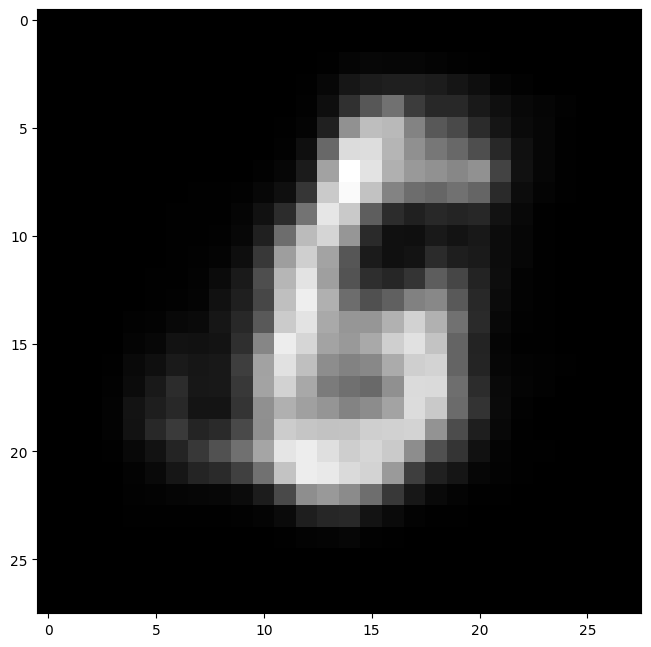

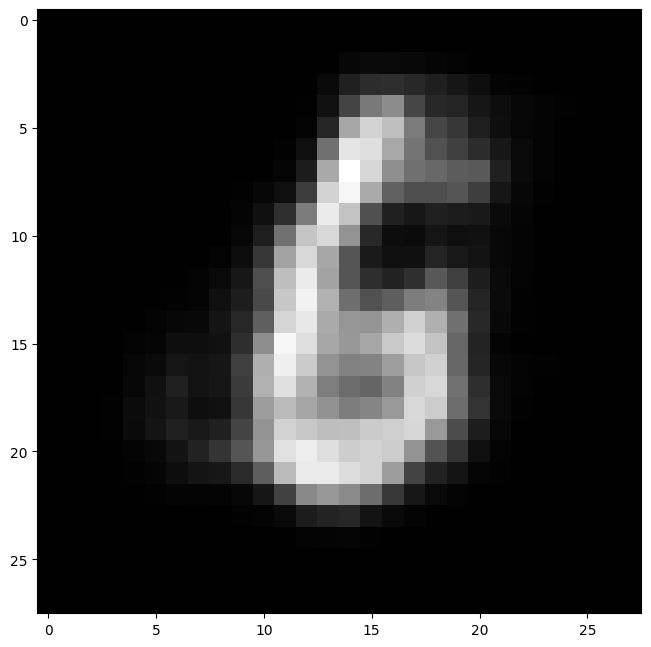

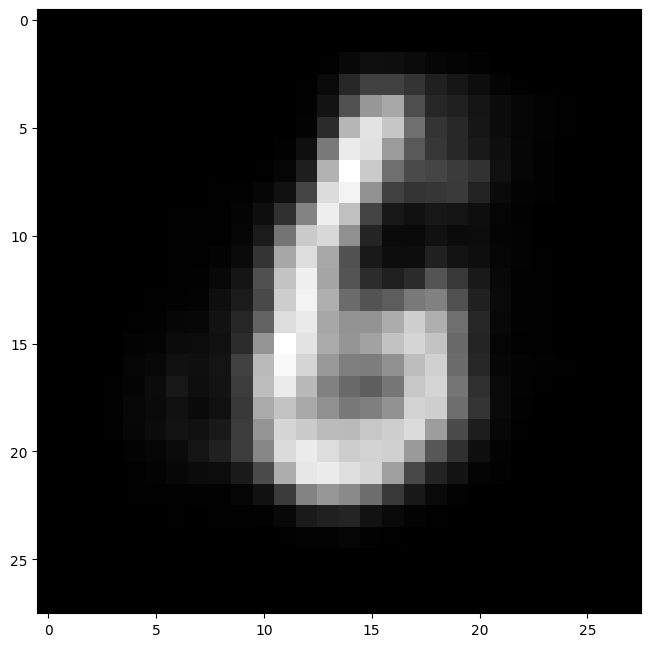

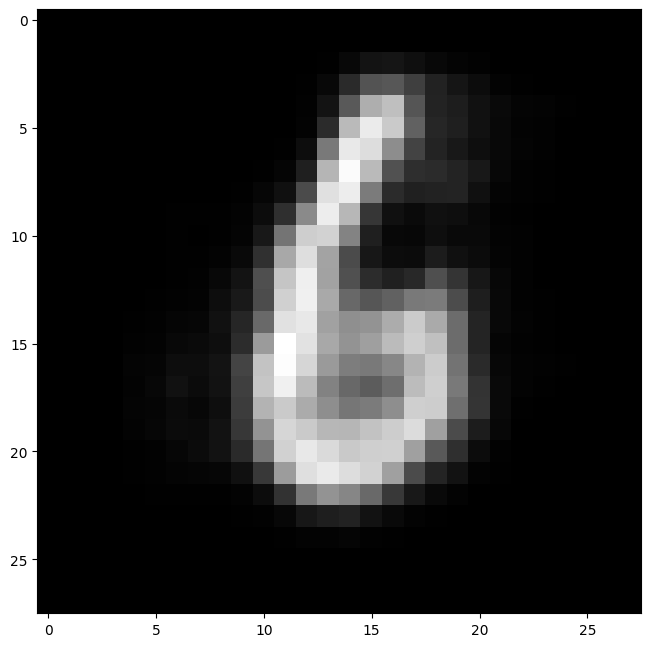

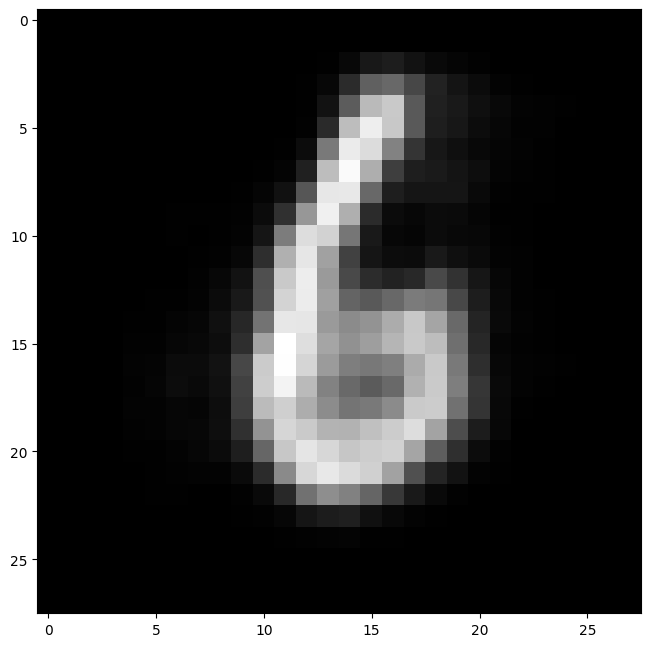

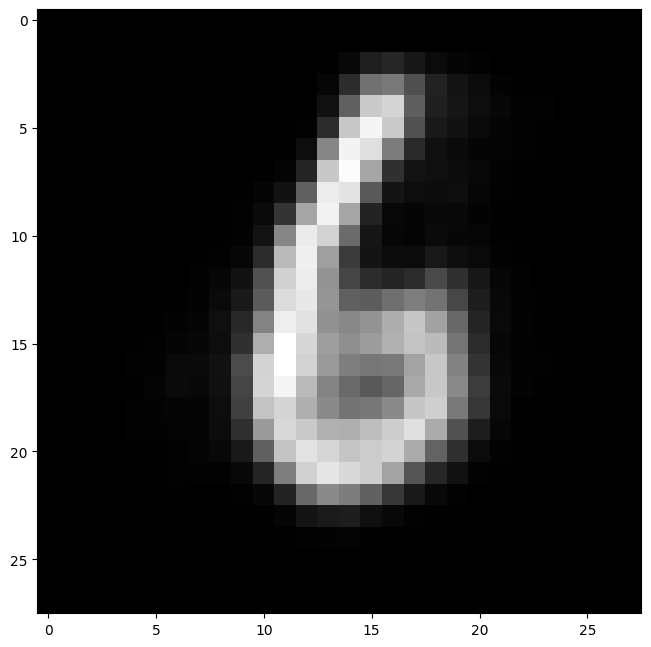

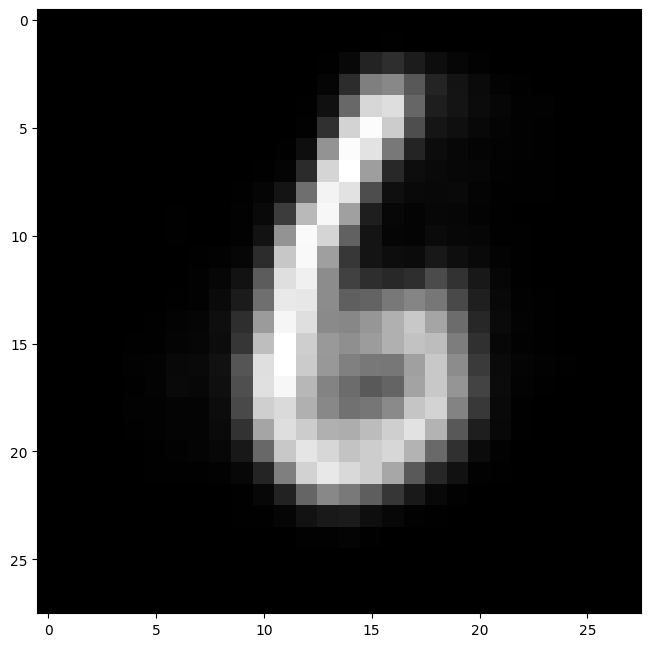

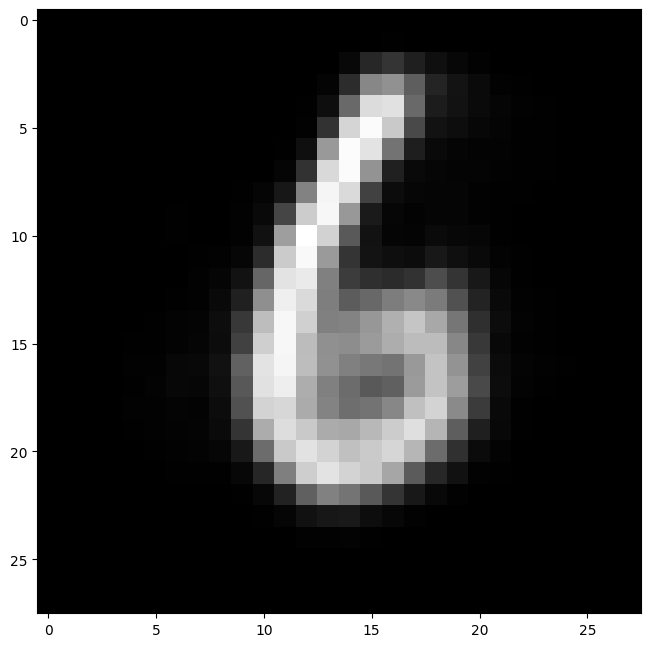

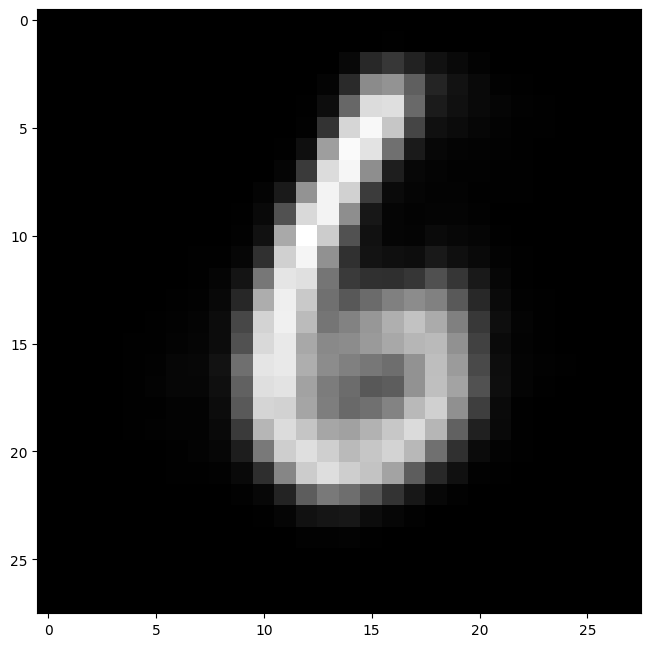

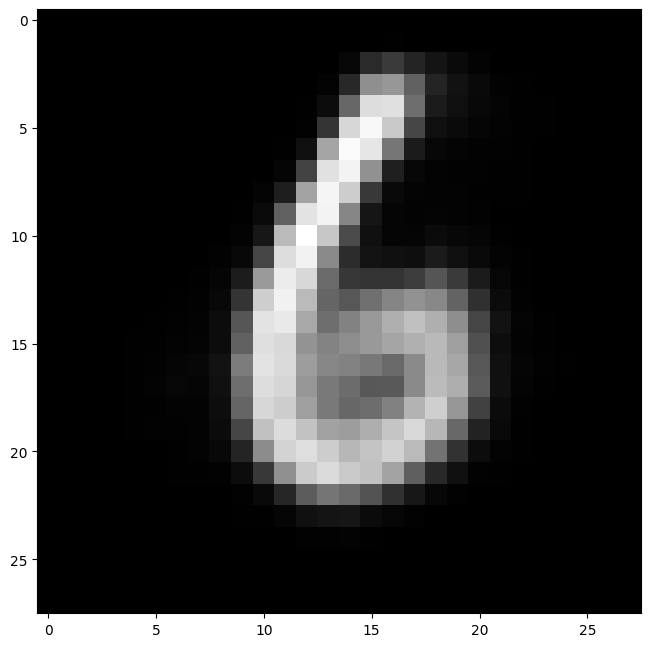

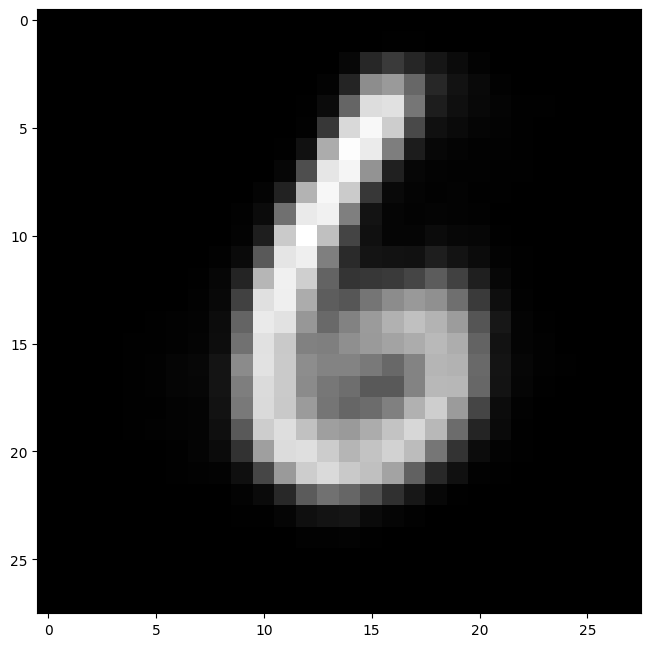

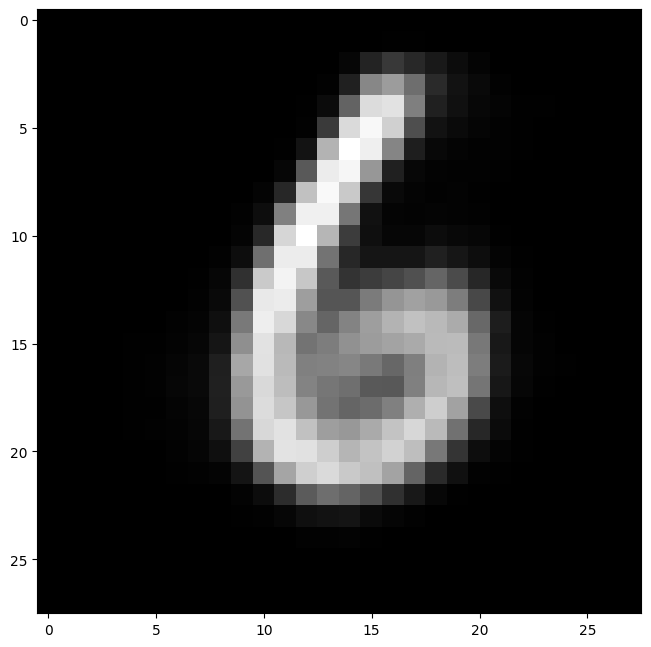

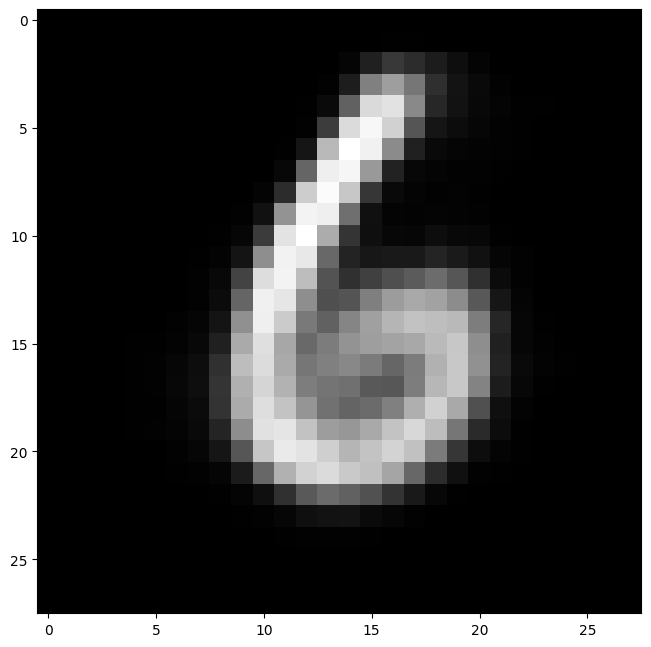

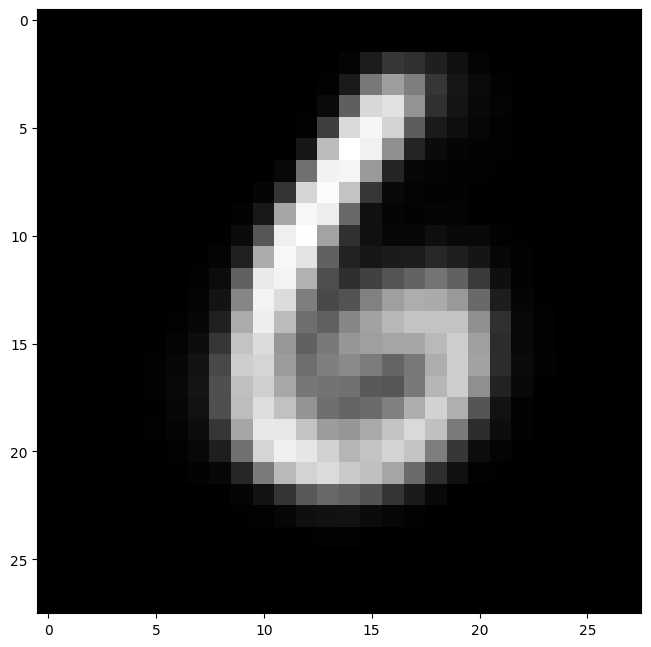

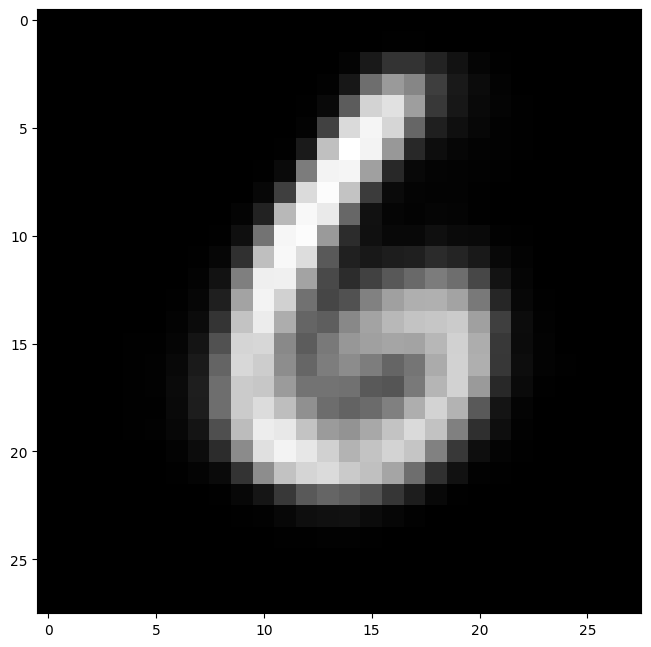

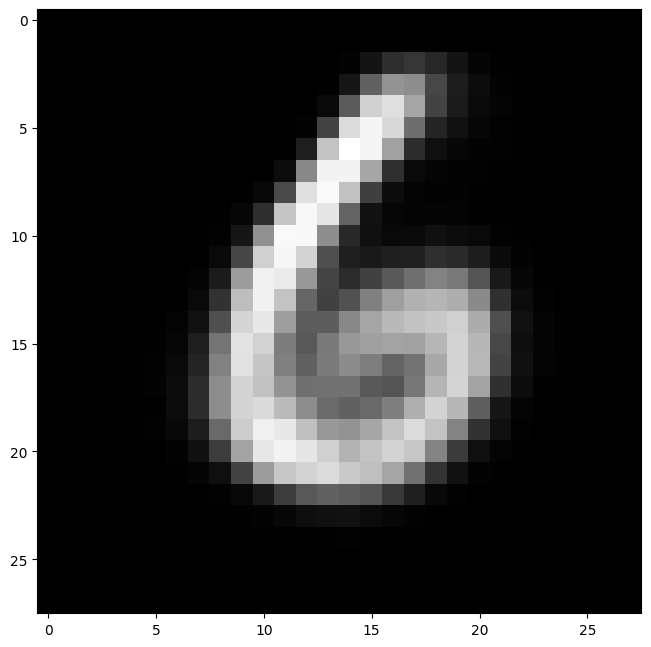

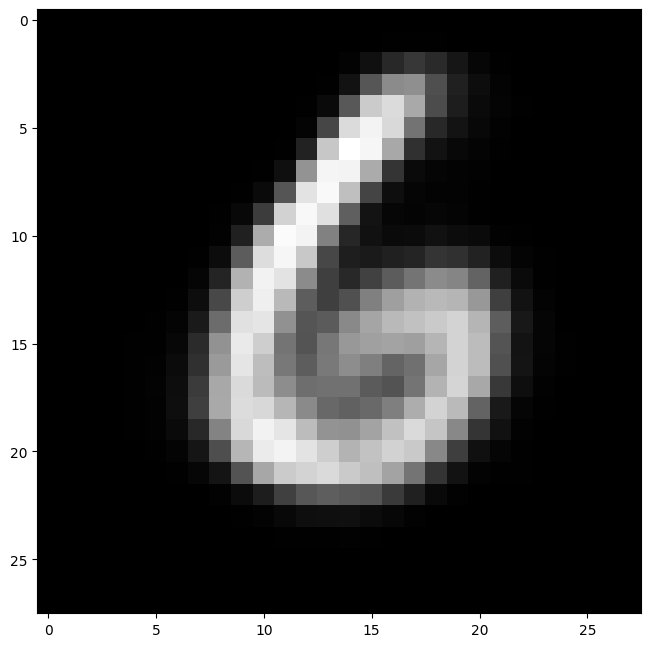

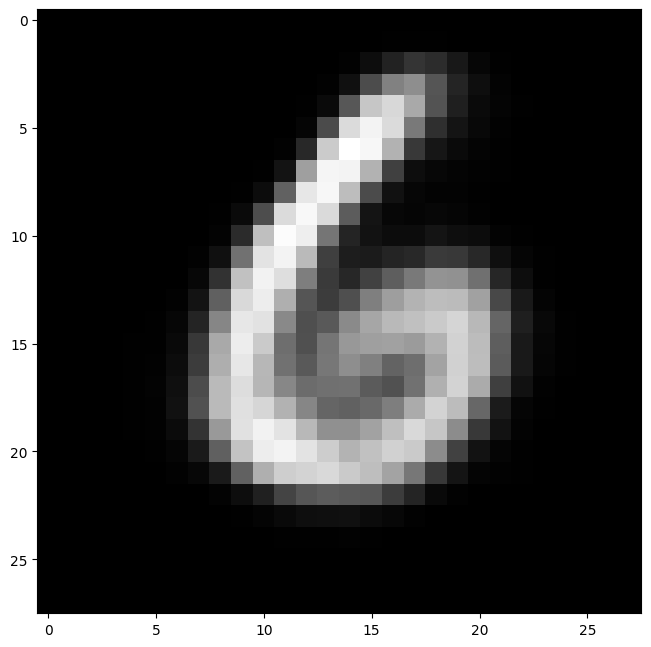

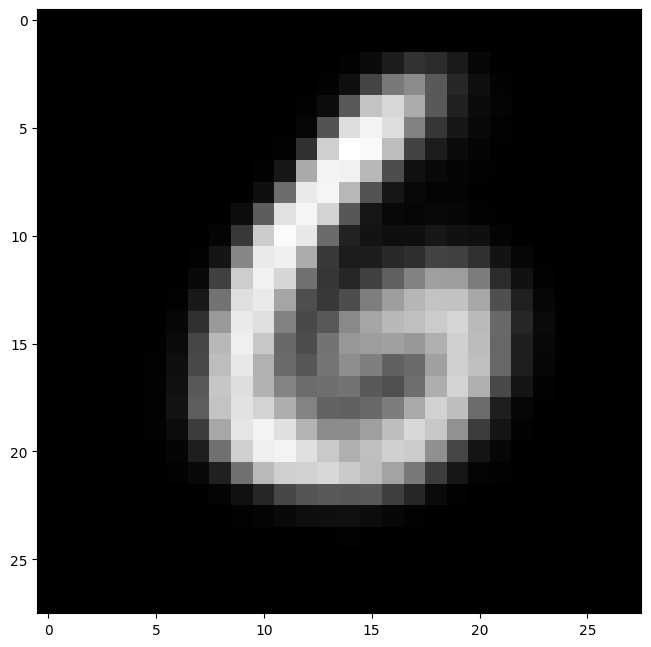

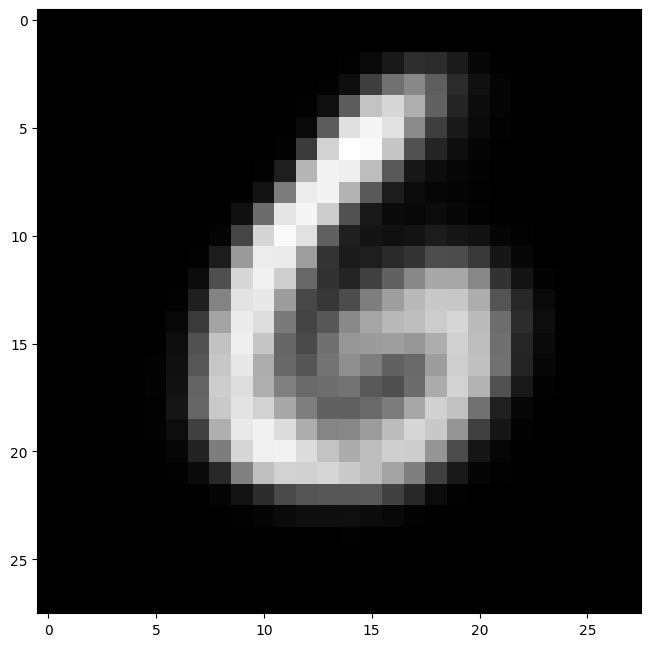

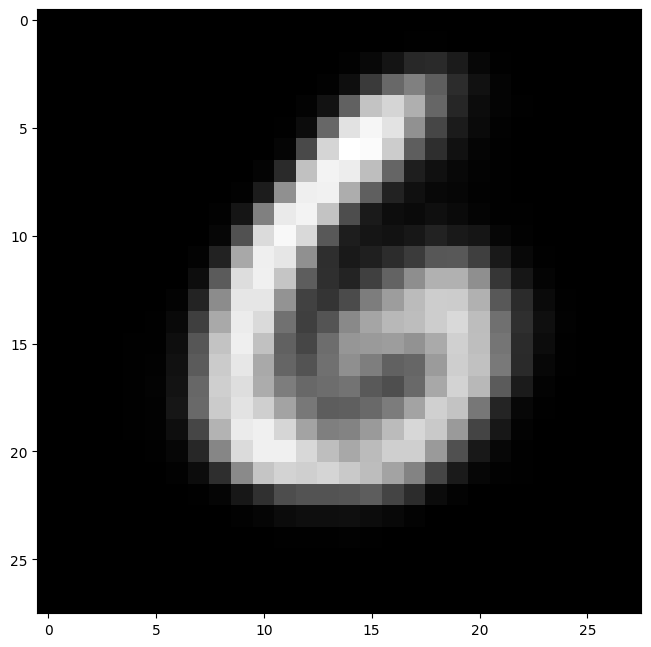

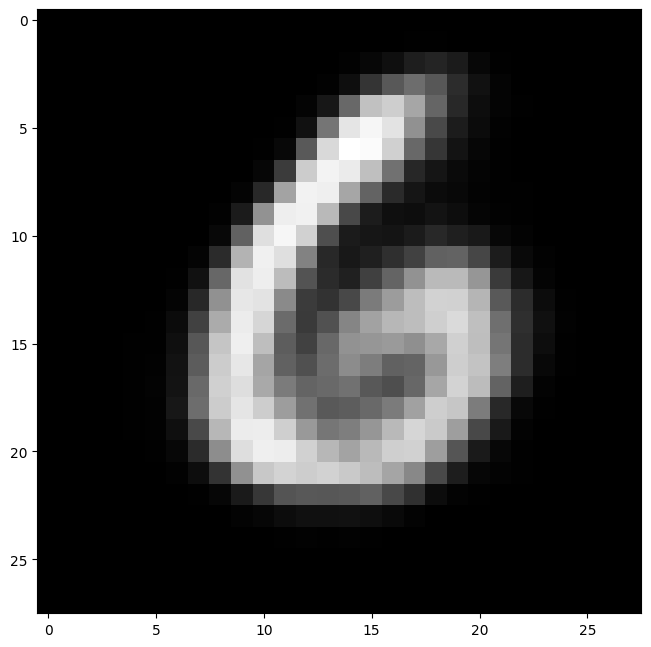

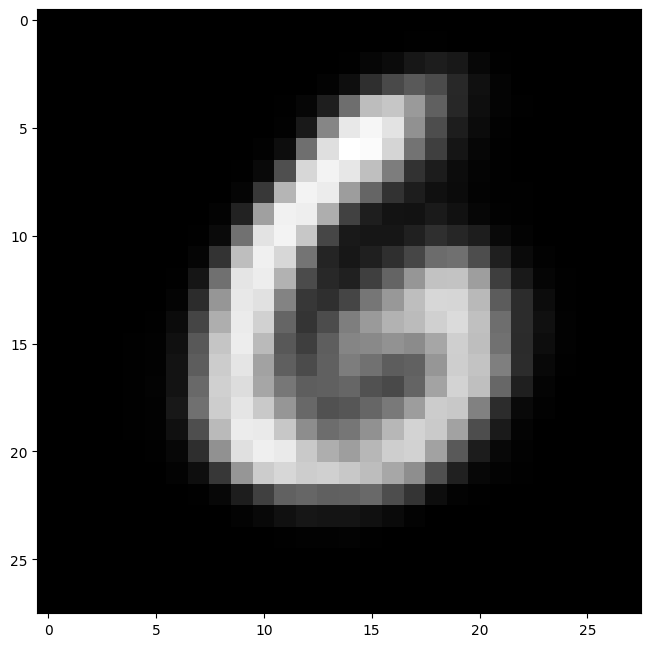

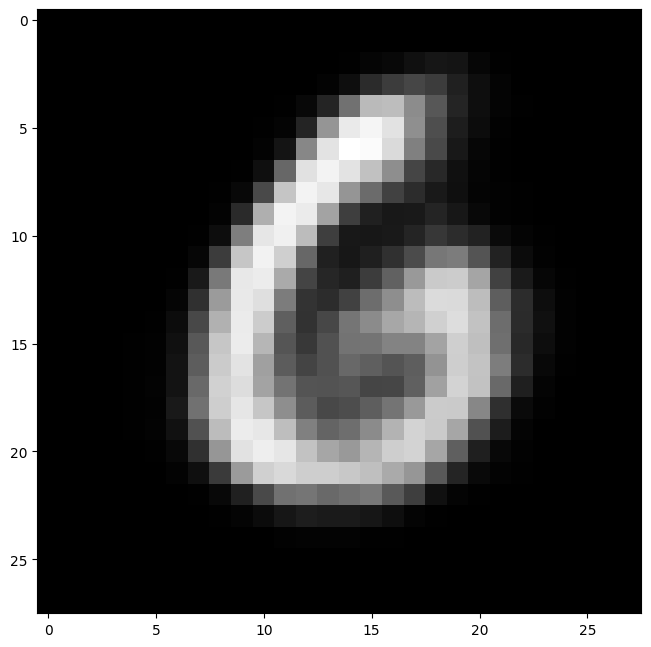

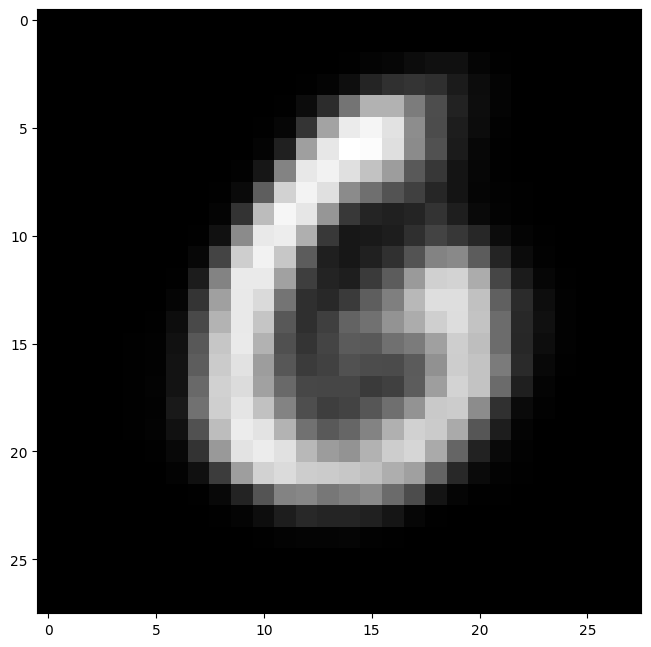

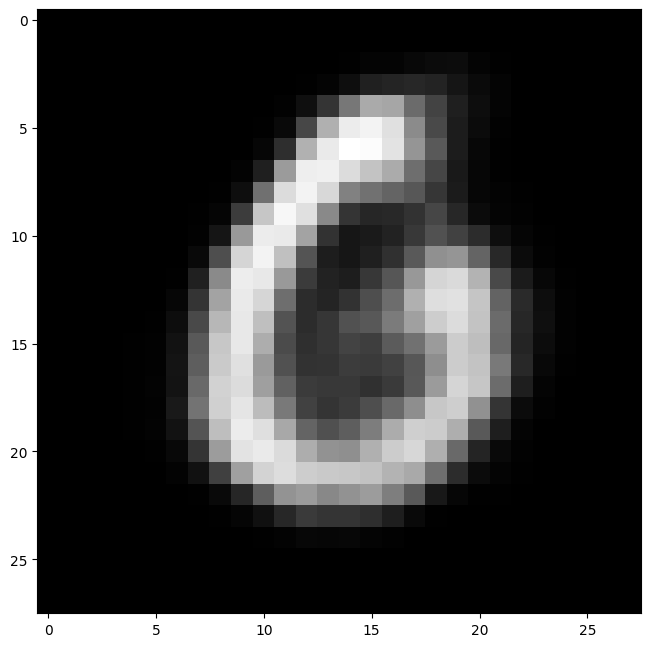

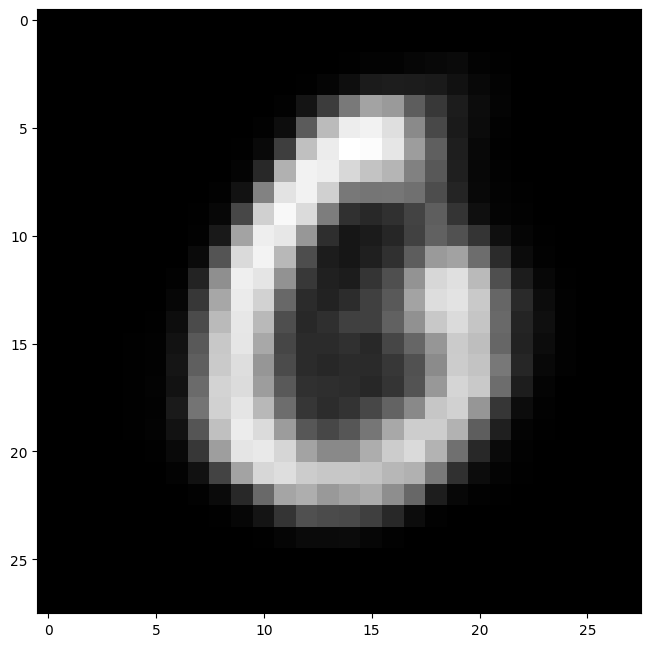

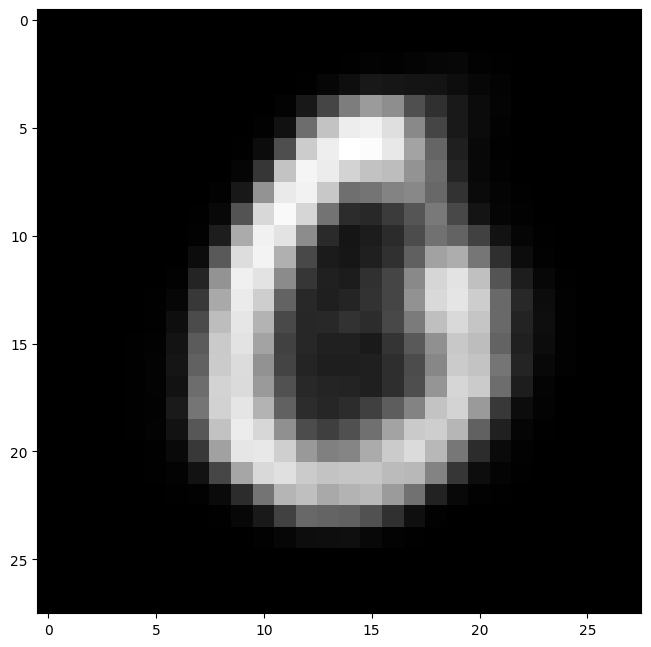

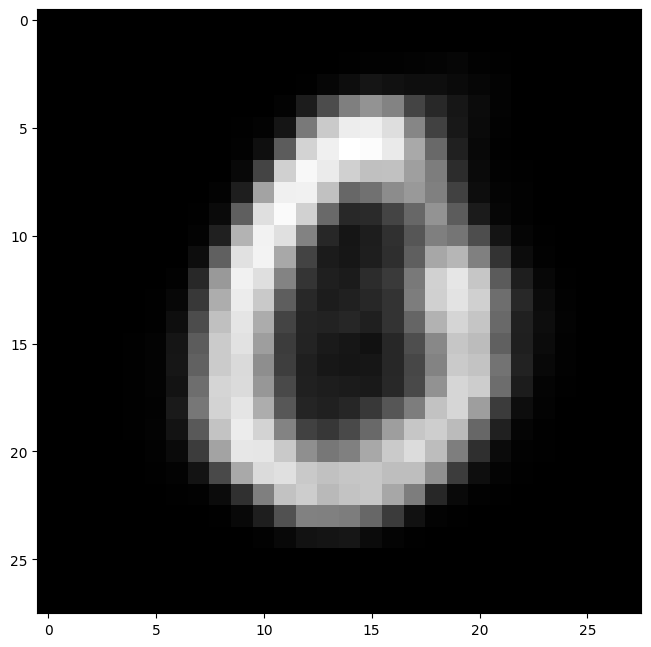

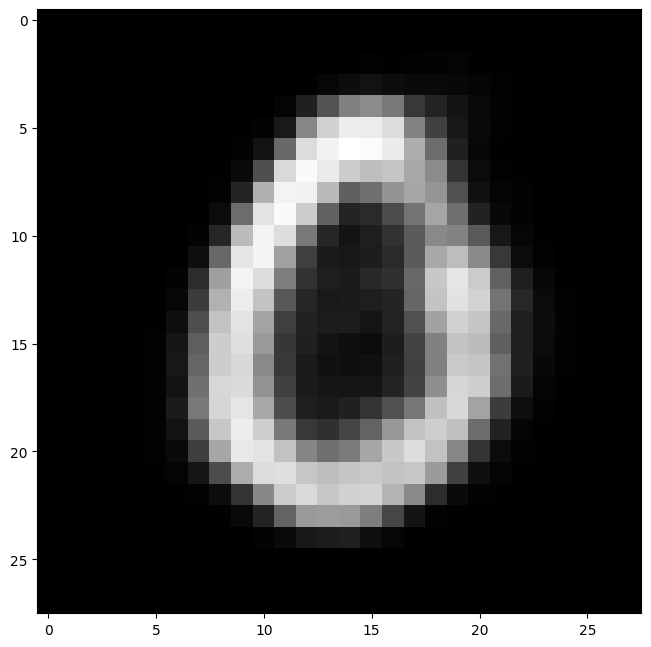

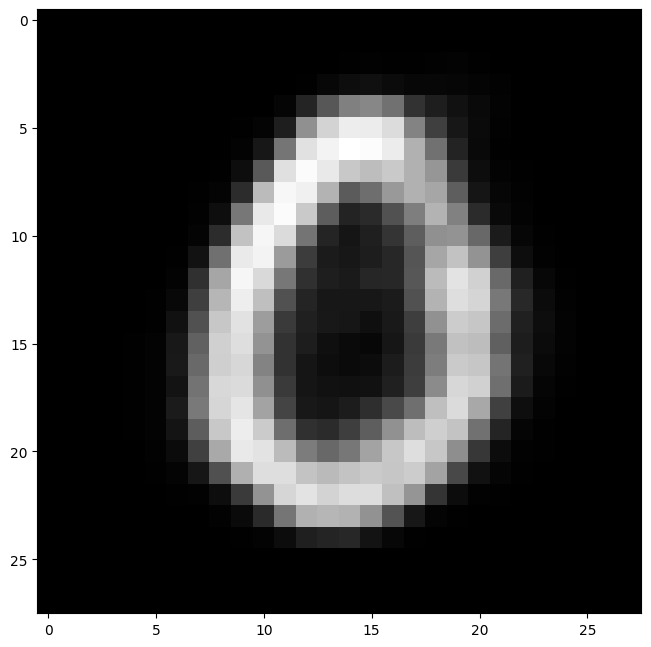

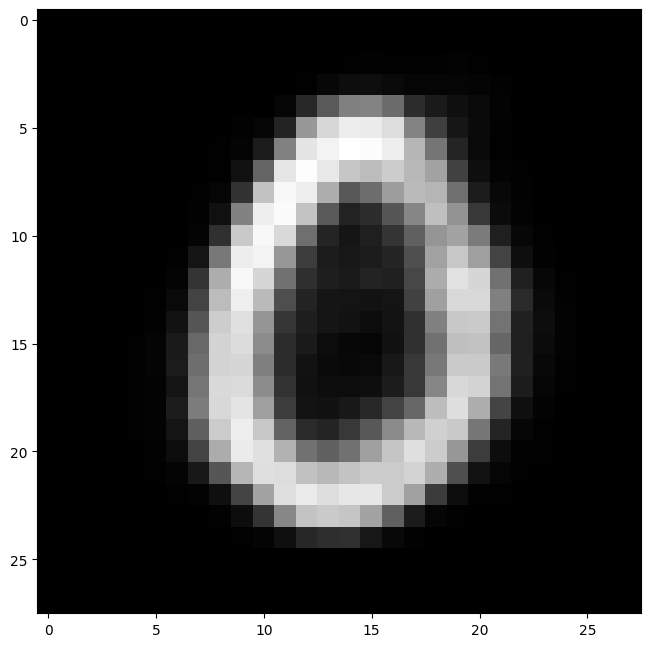

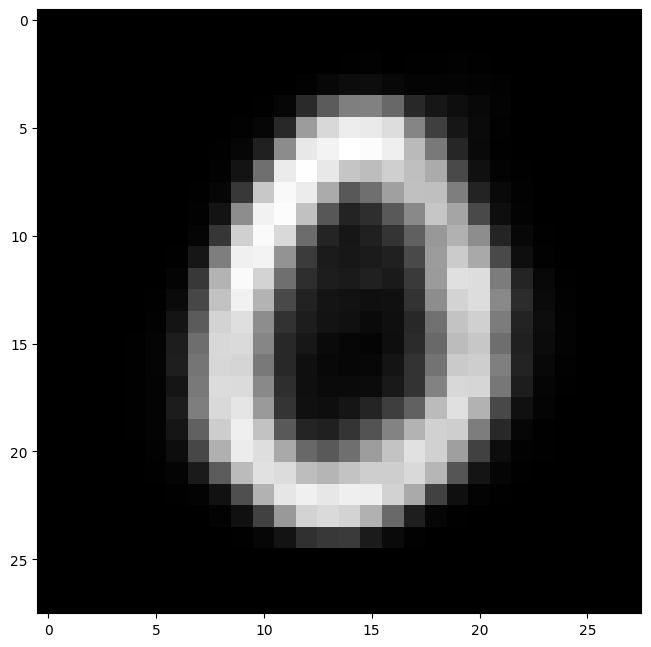

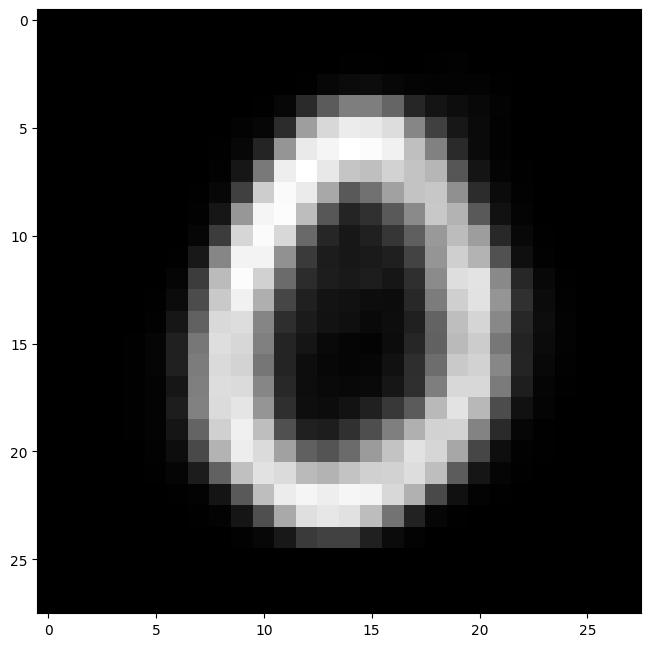

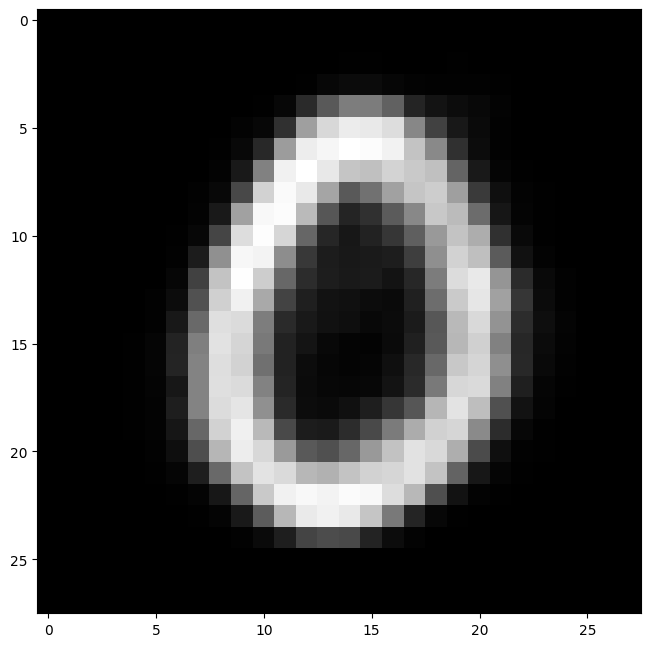

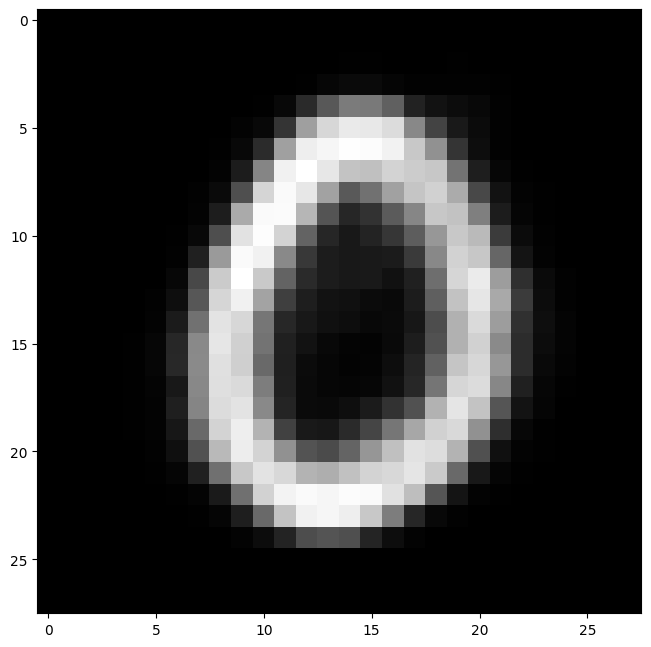

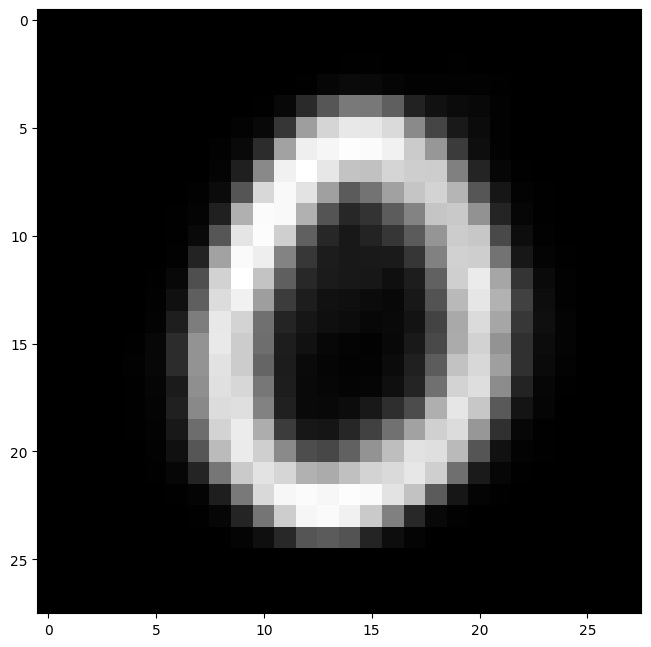

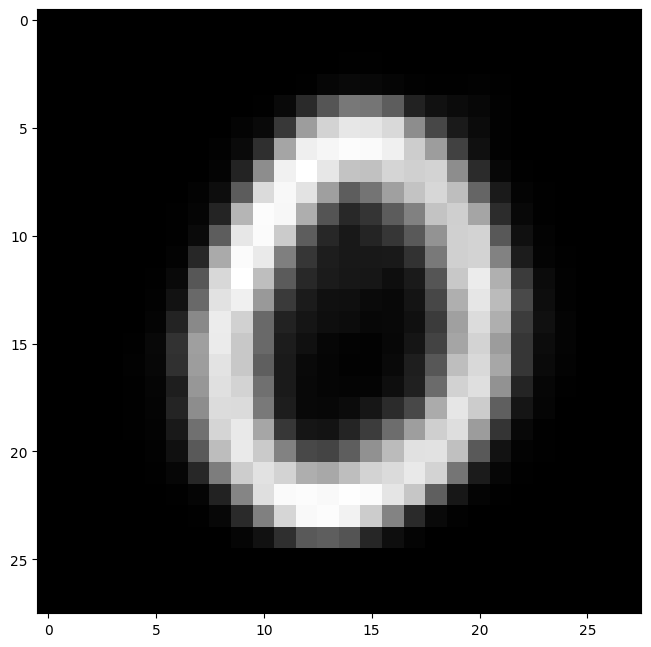

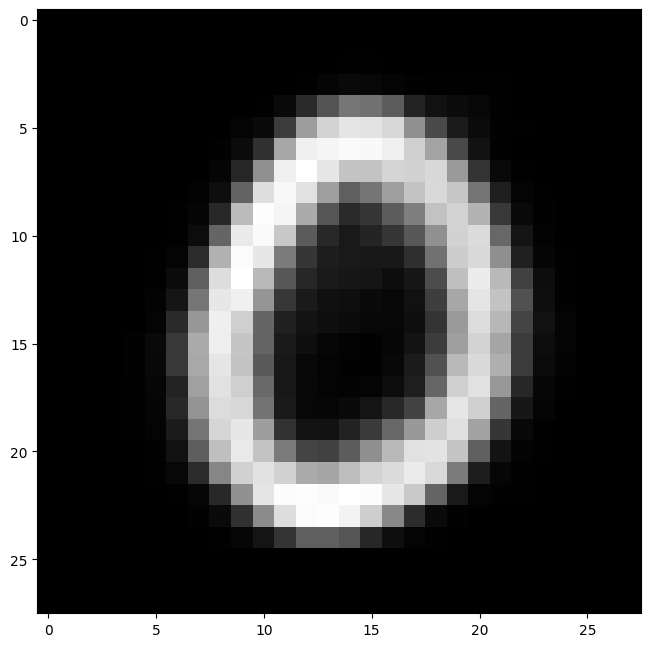

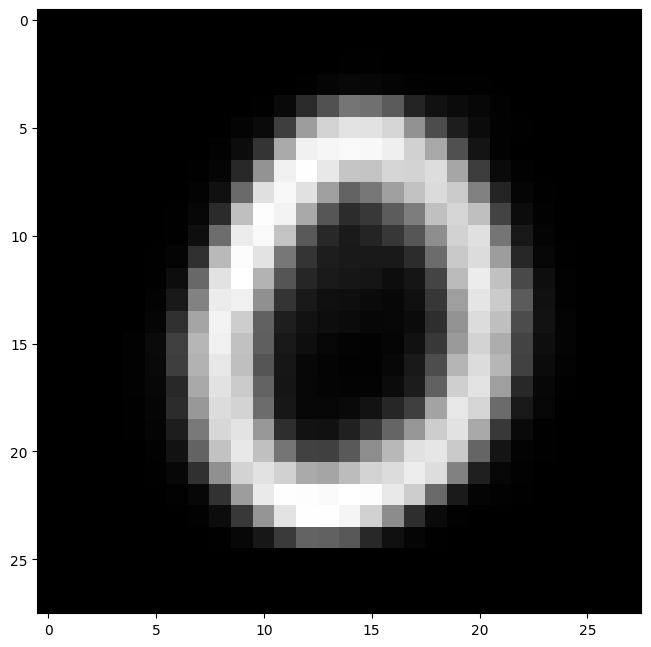

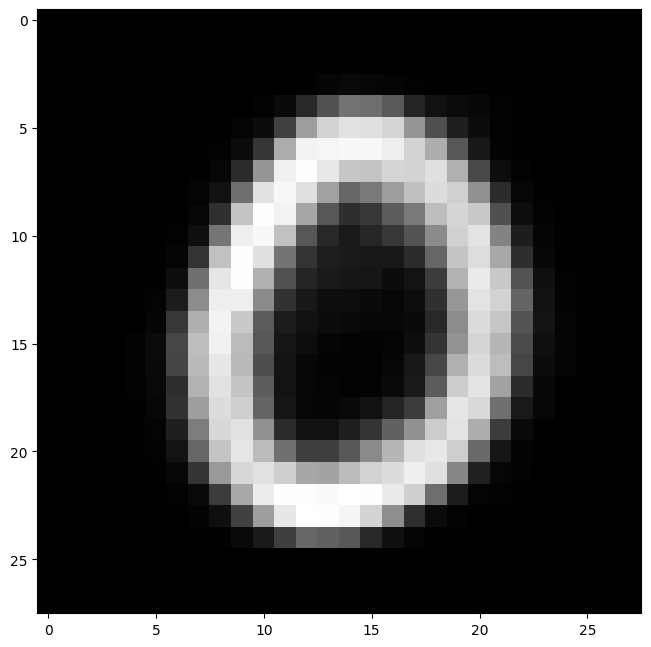

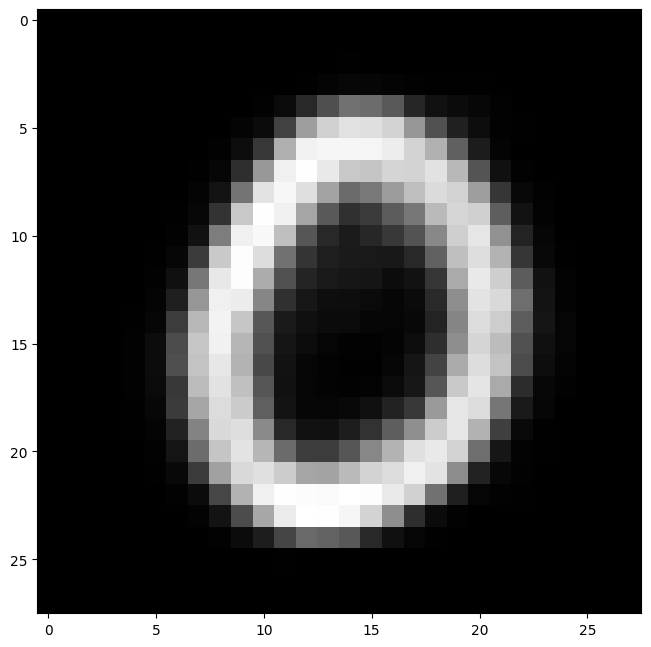

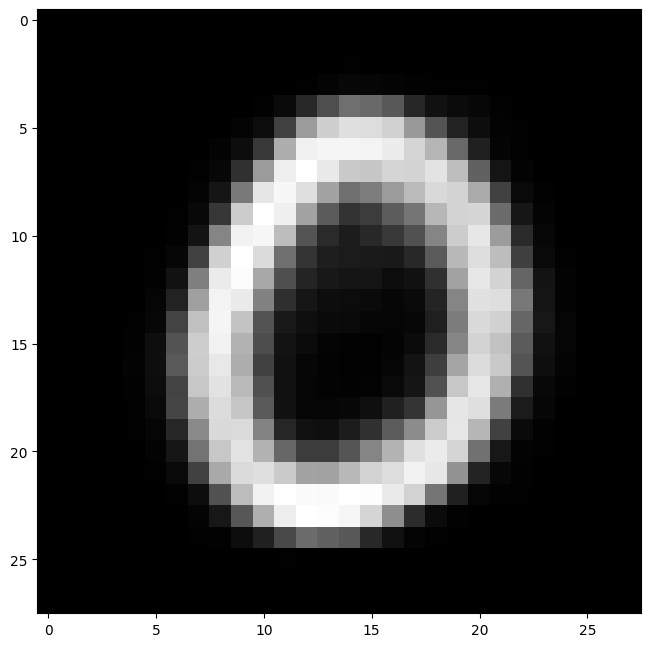

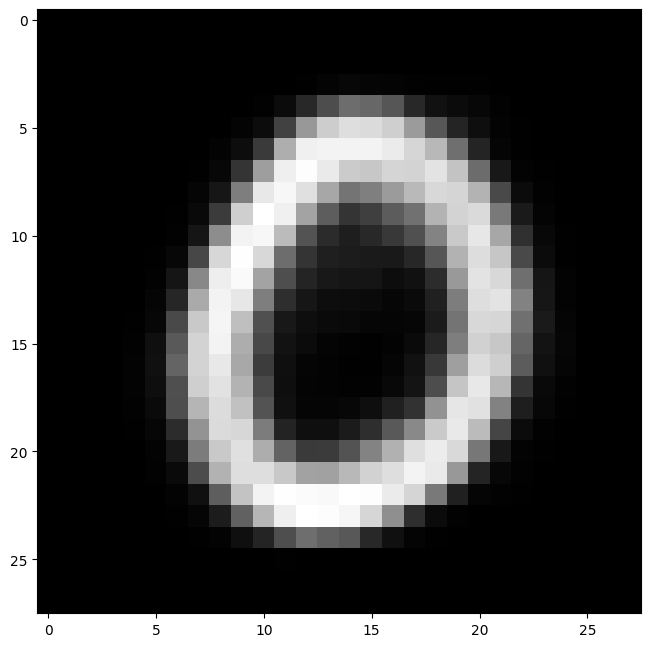

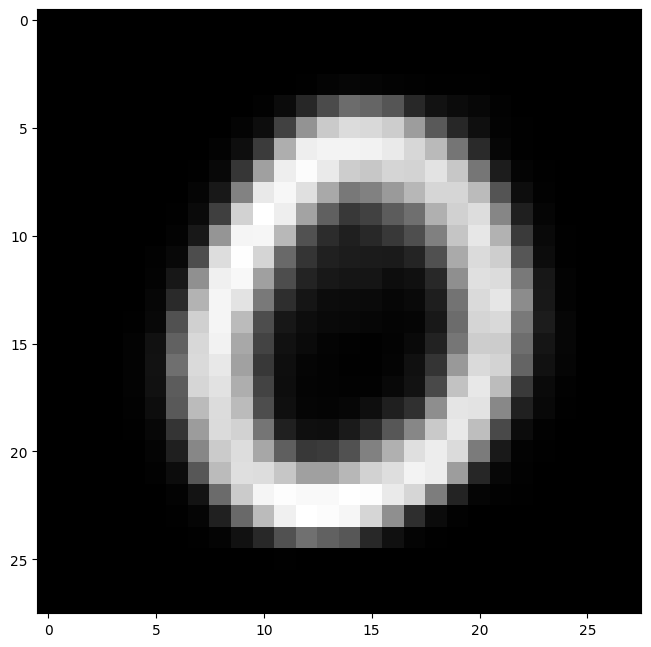

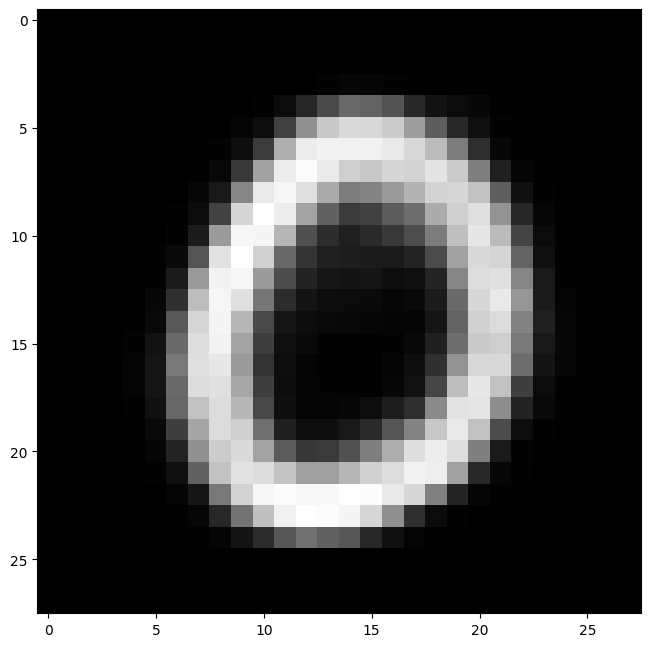

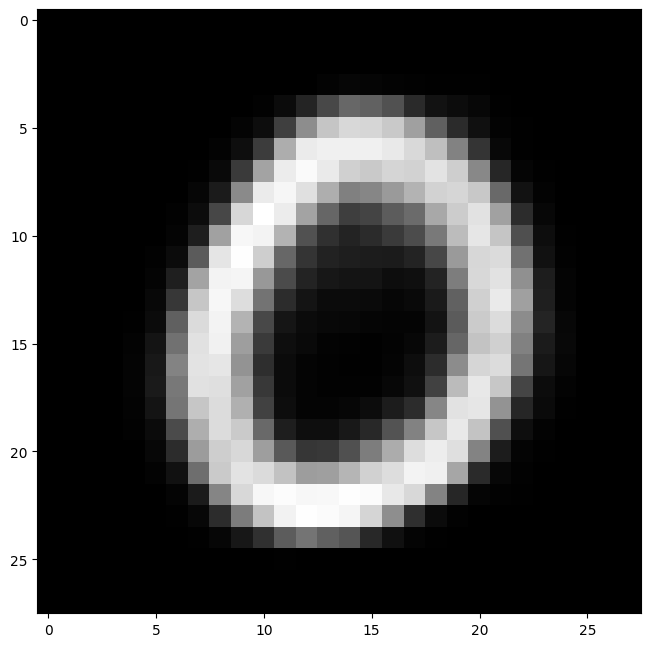

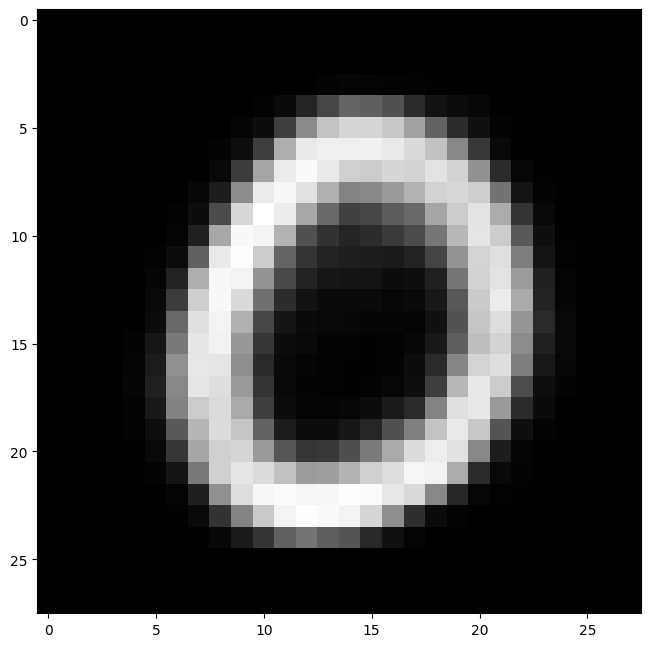

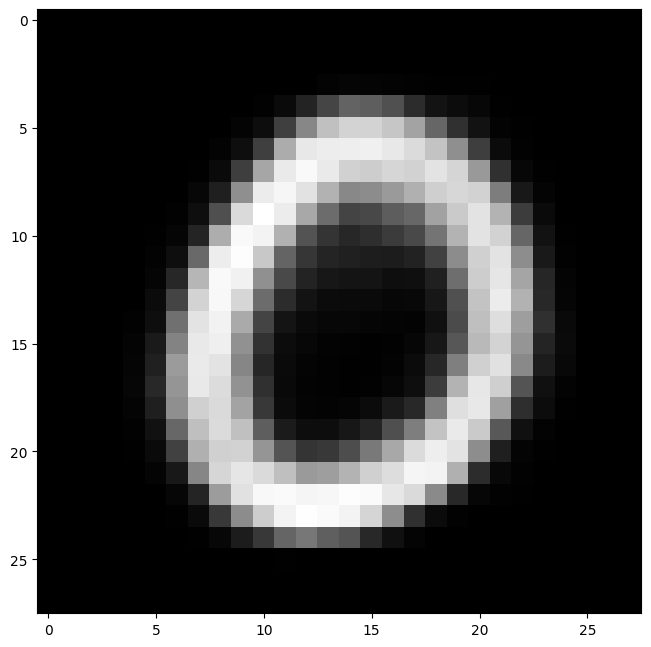

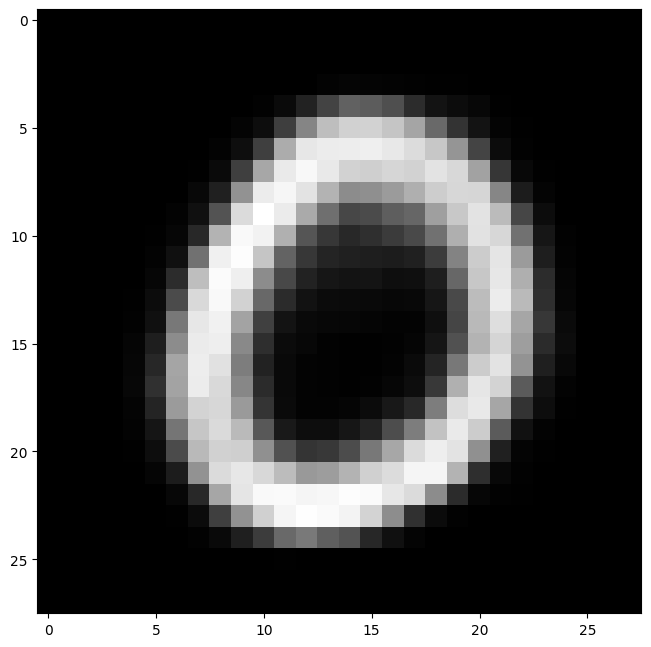

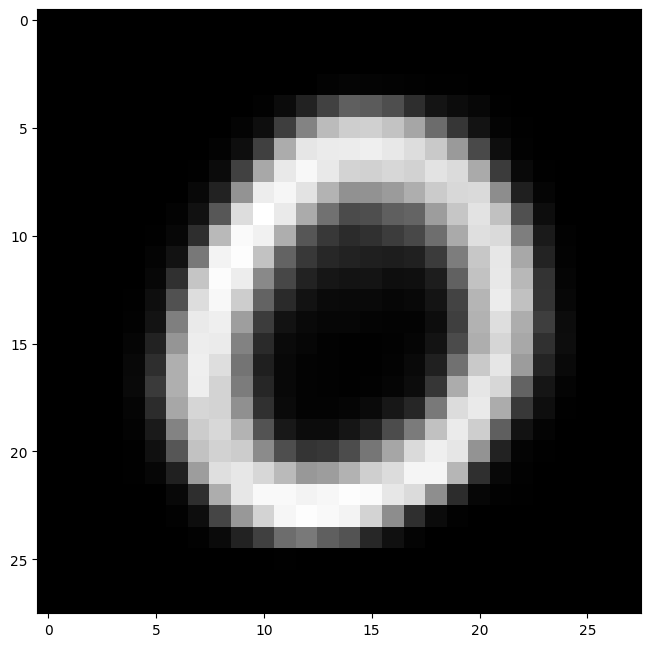

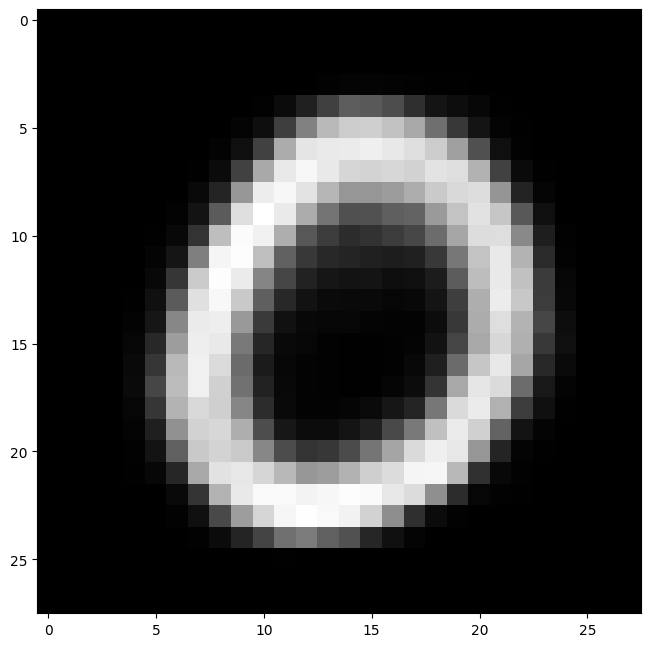

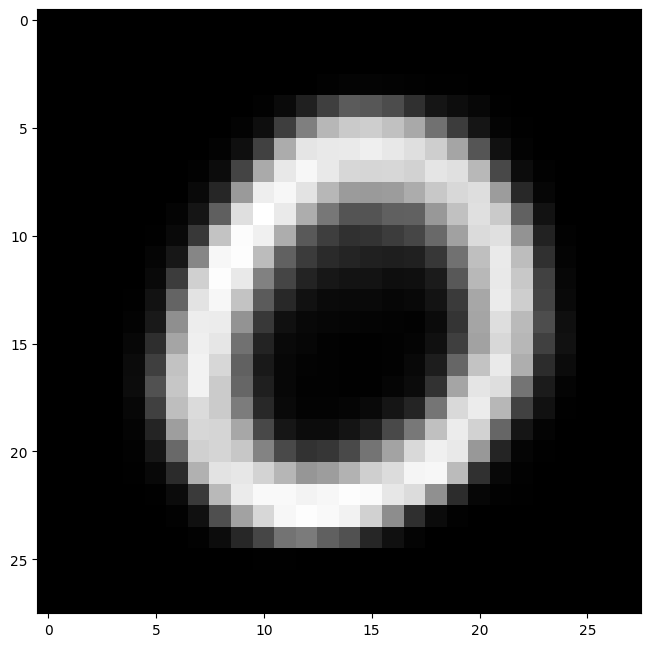

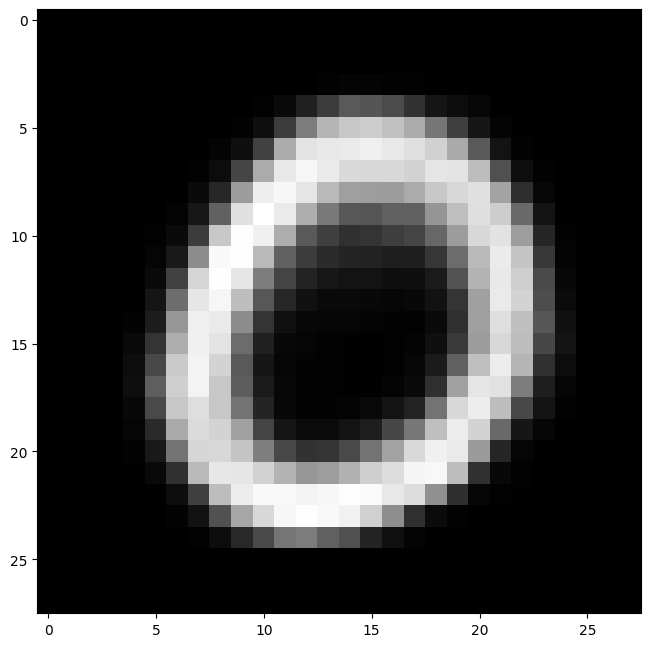

In [28]:
for i in range(100):
    data = np.array([[-1.5 + i/20, 0]])
    output = model.predict(data)
    plt.imshow(output[0, :, :, 0], cmap='gray')
    plt.show()

In [15]:
output.shape

(1, 28, 28, 1)